In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables
import gc
import gzip
from scipy.sparse import coo_matrix
from sklearn.preprocessing import normalize
import pickle

# Load raw TCCs into memory

In [3]:
# tsvfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/MemoryNaive/TCC_output/matrix.tsv'
# COOinput = pd.read_csv( tsvfile_dir, delimiter='\t',header=None, dtype=int)

# A=COOinput.as_matrix()

# rows,cols,data = A.T

In [4]:
# nonzero_ec = np.unique(rows)
# map_rows = { val:ind for ind,val in enumerate( nonzero_ec ) }
# map_cols = { val:ind for ind,val in enumerate( np.unique(cols) ) }
# TCCmatrix   = coo_matrix( (data.astype(float),( [map_rows[r] for r in rows], [map_cols[c] for c in cols]) ) ) 

# NUM_OF_CELLS = TCCmatrix.shape[1]
# print("NUM_OF_CELLS =", NUM_OF_CELLS)
      
# T = TCCmatrix.tocsr()
# # T_norm = normalize(T, norm='l1', axis=0) 
# # T_normT = T_norm.transpose()

In [5]:

# del TCCmatrix,map_cols,map_rows,A,rows,cols,data;
# _ = gc.collect()

In [6]:
# ecfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/MemoryNaive/TCC_output/matrix.ec'
# eclist=pd.read_csv( ecfile_dir, delimiter='\t',header=None, dtype=str)
# eclist=np.array(eclist)

In [7]:
# cellfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/MemoryNaive/TCC_output/matrix.cells'
# celllist=pd.read_csv( cellfile_dir, delimiter='\t',header=None, dtype=str)
# print(celllist.iloc[123][0][10:-1])

In [8]:
# cellnames=[]
# for i in range(len(celllist.index)):
#     cellnames+=[celllist.iloc[i][0][10:-1]]
# cellnames=np.array(cellnames)

In [9]:
# #Save data
# with open("./TCC_matrix_MNC.dat", 'wb') as f:
#     pickle.dump(T,f)
# with open("./nonzero_ec_MNC.dat", 'wb') as f:
#     pickle.dump(nonzero_ec,f)
# with open("./eclist_MNC.dat", 'wb') as f:
#     pickle.dump(eclist,f)
# with open("./cellnames_MNC.dat", 'wb') as f:
#     pickle.dump(cellnames,f)
    


##  Load pickled TCCs

In [10]:
#Load dataset   
with open("./TCC_matrix_MNC.dat", 'rb') as f:
    T=pickle.load(f)
with open("./nonzero_ec_MNC.dat", 'rb') as f:
    nonzero_ec=pickle.load(f)
with open("./eclist_MNC.dat", 'rb') as f:
    eclist=pickle.load(f)
with open("./cellnames_MNC.dat", 'rb') as f:
    cellnames=pickle.load(f)
    
# T_norm = normalize(T, norm='l1', axis=0)
# T_normT = T_norm.T   

### quality control

In [11]:
# median umis per cell
print("median UMIs per cell:",np.median(np.array((np.sum(T,axis=0))).reshape(1,-1)[0]))

median UMIs per cell: 5248.0


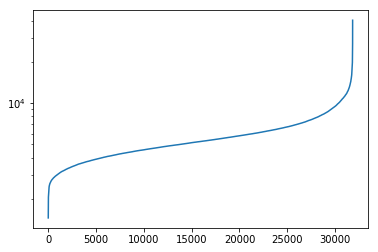

In [12]:
readspercell=np.array((np.sum(T,axis=0))).reshape(1,-1)[0]
plt.semilogy(np.sort(readspercell))

In [13]:
hi_low=[30000,1000]
cells_keep = np.where(readspercell<hi_low[0])[0]
idx = np.where(readspercell[cells_keep]>hi_low[1])[0]
cells_keep=cells_keep[idx]

In [14]:
cellnames = cellnames[cells_keep]

In [15]:
cells_keep.shape

(31831,)

In [16]:
T=T[:,cells_keep]

#### ECdict

In [17]:
EC_dict = {}
for i in range(np.shape(eclist)[0]):
    EC_dict[i] = [int(x) for x in eclist[i,1].split(',')]
    
union=set()
for i in nonzero_ec:
    new = [tx for tx in EC_dict[i] if tx not in union] # filter out previously seen transcripts
    union.update(new) 
union_list=np.sort(list(union)) #union of all transctipt ids seen in nonzero eq.classes
NUM_OF_TX_inTCC = len(union)
print("NUM_OF_Transcripts =", NUM_OF_TX_inTCC) #number of distinct transcripts in nonzero eq. classes 

NUM_OF_Transcripts = 133211


In [18]:
path_to_ref='/home/vasilis/clustering_EQ/Human_reference/Homo_sapiens.GRCh38.rel79.cdna.all.fa.gz'

def readENS_ids(path_to_ref):
    TX_to_ENST={}
    TX_to_ENSG={}
    ENSG_isoforms={}
    line_cnt=0;
    tx_cnt=0;
    with gzip.open(path_to_ref) as f:
        for line in f:
            if line.decode('UTF-8')[0]=='>':
                liner=line.decode('UTF-8')
                if line_cnt == union_list[tx_cnt]:
                    TX_to_ENST[union_list[tx_cnt]] = 'ENST'+liner.split("ENST",1)[1][:11]
                    TX_to_ENSG[union_list[tx_cnt]] = 'ENSG'+liner.split("ENSG",1)[1][:11]
                    ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]] = ENSG_isoforms.get(TX_to_ENSG[union_list[tx_cnt]], [])
                    ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]].append(TX_to_ENST[union_list[tx_cnt]])
                    tx_cnt+=1 
                    if tx_cnt==NUM_OF_TX_inTCC: return [TX_to_ENST,TX_to_ENSG,ENSG_isoforms]
                line_cnt+=1
    return [TX_to_ENST,TX_to_ENSG,ENSG_isoforms]


[TX_to_ENST,TX_to_ENSG,ENSG_isoforms]=readENS_ids(path_to_ref)       

In [19]:
EC_ENST_DICT={}
EC_ENSG_DICT={}
for ec in nonzero_ec:
    EC_ENST_DICT[ec] = [TX_to_ENST[tx] for tx in EC_dict[ec]]    
    EC_ENSG_DICT[ec] = list(np.unique([TX_to_ENSG[tx] for tx in EC_dict[ec]])) 

In [20]:
ENST_to_TX = {v: k for k, v in TX_to_ENST.items()}

In [21]:
#inv_map ; NOTE: genes and transcripts may be associated with multiple ensg accession numbers
ENSG_EC_DICT={}
for k, v in EC_ENSG_DICT.items():
    for vi in v:
        ENSG_EC_DICT[vi] = ENSG_EC_DICT.get(vi, [])
        ENSG_EC_DICT[vi].append(k)
        
ENST_EC_DICT={}
for k, v in EC_ENST_DICT.items():
    for vi in v:
        ENST_EC_DICT[vi] = ENST_EC_DICT.get(vi, [])
        ENST_EC_DICT[vi].append(k)

In [22]:
all_genes_ids = np.unique(list(TX_to_ENSG.values()))
print("NUM_OF_GENE_IDs =", len(all_genes_ids))

NUM_OF_GENE_IDs = 25940


In [23]:
clean_gene_ids=[]

for gene in all_genes_ids:
    if len(list(np.unique([EC_ENSG_DICT[ec] for ec in ENSG_EC_DICT[gene]]))) == 1:
        clean_gene_ids+=[gene]
clean_gene_ids=np.array(clean_gene_ids)

In [24]:
print("NUM_OF_CLEAN_GENE_IDs =", len(clean_gene_ids))

NUM_OF_CLEAN_GENE_IDs = 6234


#### gene names

In [25]:
# #gene ids to gene names (requires "pip install mygene")
# import mygene
# mg = mygene.MyGeneInfo()
# ginfo = mg.querymany(all_genes_ids, scopes='ensembl.gene',returnall=True)

# with open('ginfo_MNC.pickle', 'wb') as handle:
#     pickle.dump(ginfo, handle, protocol=pickle.HIGHEST_PROTOCOL)

#LOAD
with open('ginfo_MNC.pickle', 'rb') as handle:
    ginfo = pickle.load(handle)

In [26]:
missing_names=ginfo['missing']
duplicate_names=ginfo['dup']

In [27]:
#ENSG to Gene-Names
all_gene_id_to_names={} #missing are mapped to their ENSG id, Duplicates to a list of names
count_exept=0
for g in ginfo['out']:
    try:
        ensg_id=str(g['query'])
        all_gene_id_to_names[ensg_id] = all_gene_id_to_names.get(ensg_id, [])
        all_gene_id_to_names[ ensg_id].append(str(g['symbol']))                
    except KeyError:
        count_exept=count_exept+1
        all_gene_id_to_names[ str(g['query']) ] = [str(g['query'])]
        
#Gene-Names to ENSG
all_gene_names_to_id={} #missing are mapped to their ENSG id, Duplicates to a list of names
count_exept=0
for g in ginfo['out']:
    try:
        gene_name=str(g['symbol'])
        all_gene_names_to_id[gene_name] = all_gene_names_to_id.get(gene_name, [])
        all_gene_names_to_id[ gene_name].append(str(g['query']))                
    except KeyError:
        count_exept=count_exept+1
        all_gene_names_to_id[ str(g['query']) ] = [str(g['query'])]

In [28]:
def search_gene(starting_letters):
    print("SEARCHING: ",starting_letters,"...")
    for gene in all_genes_ids:
        if all_gene_id_to_names[gene][0][:len(starting_letters)] == starting_letters:
            print(gene,all_gene_id_to_names[gene])
    print("DONE")

In [29]:
EC_IDX={}
for i in range(len(nonzero_ec)):
    EC_IDX[nonzero_ec[i]] =i 

# PTPRC

In [30]:
gene="PTPRC"
all_gene_names_to_id[gene]

['ENSG00000081237', 'ENSG00000262418']

In [31]:
gene_ecs0=[]
for g in all_gene_names_to_id[gene]:
    gene_ecs0+=ENSG_EC_DICT[g]
gene_ecs0=np.unique(gene_ecs0)

In [32]:
gene_ecs0

array([185825, 199819, 211359, 224159, 232661, 238957, 246503, 247023,
       250045, 250930, 252809, 260768, 274831, 288014, 297171, 314713,
       330776, 364464, 428740, 512155, 572140, 577209, 599451, 599452,
       599453, 615875, 656355, 658929, 658930, 658931, 658932, 658933,
       689589, 712829, 713742, 715513, 722147, 745938])

In [33]:
ec_counts=[]
for ec in gene_ecs0:
    ec_counts+=[T[EC_IDX[ec],:].sum()]
ec_nnz_cell_counts=[]
for ec in gene_ecs0:
    ec_nnz_cell_counts+=[T[EC_IDX[ec],:].nnz] 
    

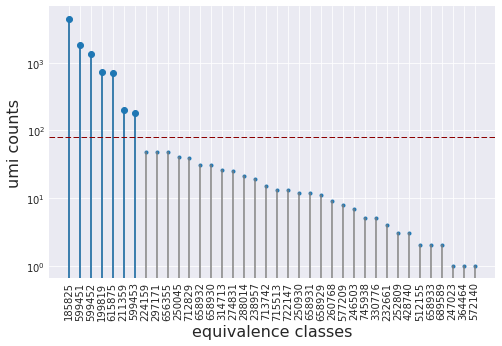

In [34]:
sns.set_style("darkgrid")

threshold=0.0025*T.shape[1]

gene_ecs=gene_ecs0[np.where(np.array(ec_counts)>threshold)[0]]
upto=len(gene_ecs)

plt.figure(figsize=(8,5))
plt.stem(range(len(ec_counts)),np.sort(ec_counts)[::-1],'gray',markerfmt='.')

plt.xticks(range(len(ec_counts)),gene_ecs0[np.argsort(ec_counts)[::-1]],rotation='vertical')
# plt.xlim([0,len(b)+0.9])

plt.stem(range(upto),np.sort(ec_counts)[::-1][:upto])

plt.axhline(y=threshold, color='darkred', linestyle='--',linewidth=1)
plt.xlabel("equivalence classes",fontsize=16)
plt.ylabel("umi counts",fontsize=16)
plt.yscale('log')
plt.show()

In [35]:
print(gene_ecs)

[185825 199819 211359 599451 599452 599453 615875]


In [36]:
associated_genes=[]
for ec in gene_ecs:
    associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
associated_genes=np.unique(associated_genes)
print(associated_genes)

['PTPRC']


In [37]:
ecidx=np.array([EC_IDX[ec] for ec in gene_ecs])

In [38]:
ecidx

array([ 62333,  69896,  76094, 214260, 214261, 214262, 223213])

In [39]:
eq_classes=[]
for i in ecidx:
    tx_indices=EC_dict[nonzero_ec[i]]
    tx_ens=[TX_to_ENST[t] for t in tx_indices]
    eq_classes+=[tx_ens]

In [40]:
import json
eq_dict={}
for i in range(len(eq_classes)):
    eq_dict[str(ecidx[i])] = list(np.sort(eq_classes[i]))
print(json.dumps(eq_dict, indent=1))

{
 "62333": [
  "ENST00000348564",
  "ENST00000442510"
 ],
 "69896": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000442510",
  "ENST00000529828",
  "ENST00000530727",
  "ENST00000573477",
  "ENST00000573679",
  "ENST00000574441",
  "ENST00000575923",
  "ENST00000576833"
 ],
 "76094": [
  "ENST00000413409",
  "ENST00000571847"
 ],
 "214260": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000442510",
  "ENST00000529828"
 ],
 "214261": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000442510",
  "ENST00000529828",
  "ENST00000530727"
 ],
 "214262": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000442510",
  "ENST00000491302",
  "ENST00000529828",
  "ENST00000530727",
  "ENST00000573477",
  "ENST00000573679",
  "ENST00000574441",
  "ENST00000575803",
  "ENST00000575923",
  "ENST00000576833"
 ],
 "223213": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000367379",
  "ENST00000442510",
  "ENST00000529828",
  "ENST00000530727",
  "ENST00000573298",
  "ENST000

# LogR

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import statsmodels.api as sm
from scipy import stats
import math

/home/vasilis/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [42]:
labels=[]
for name in cellnames:
    if name[-1]=='N':
        labels+=[0]
    elif name[-1]=='M':
        labels+=[1]
    else:
        labels+=[2]
labels=np.array(labels)

In [43]:
def logr_ecidx(ecidx,X1,X2):
    
    N1=X1.shape[0]
    N2=X2.shape[0]
    logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
    logr = LogisticRegression()
    p_of_1=N1/float(N1+N2)
    llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
    k=len(ecidx)
    
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()
    c=np.concatenate([X1_ecidx,X2_ecidx])
    #c=np.concatenate([X1[:,ecidx],X2[:,ecidx]])
    logr.fit(c,logr_labels)
    pred=np.array(logr.predict_proba(c)[:,1])
    gene_score=log_loss(logr_labels,pred)
    llf=-gene_score*(N1+N2)
    llr=llf-llnull
    llr_pval = 1-stats.chi2.cdf(2*llr,k)
    
    return [logr,llr_pval]

In [44]:
X=T.T

In [45]:
X_naive=X[np.squeeze(labels==0),:]
X_mem=X[np.squeeze(labels==1),:]
X_cyto=X[np.squeeze(labels==2),:]




print("naive cells: ",X_naive.shape[0])
print("mem cells: ",X_mem.shape[0])
print("cyto cells: ",X_cyto.shape[0])

naive cells:  9923
mem cells:  9994
cyto cells:  11914


In [46]:
np.random.seed(0)
samples=3000

randperm1=np.random.permutation(X_naive.shape[0])
randperm2=np.random.permutation(X_mem.shape[0])
randperm3=np.random.permutation(X_cyto.shape[0])

In [47]:
sns.set_style("white")

(3000, 342638)
(3000, 342638)
pval= 9.16495524228e-06


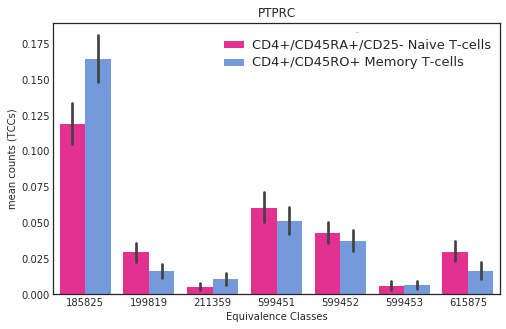

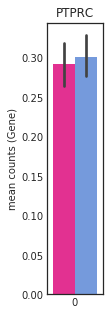

In [48]:
#positive control 

X1=X_naive[randperm1[:samples],:]
X2=X_mem[randperm2[:samples],:]


print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()

Optimization terminated successfully.
         Current function value: 0.690189
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5992
Method:                           MLE   Df Model:                            7
Date:                Wed, 13 Dec 2017   Pseudo R-squ.:                0.004268
Time:                        19:24:05   Log-Likelihood:                -4141.1
converged:                       True   LL-Null:                       -4158.9
                                        LLR p-value:                 9.017e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0202      0.028      0.721      0.471      -0.035       0.075
x1            -0.2542      0.

<Container object of 3 artists>

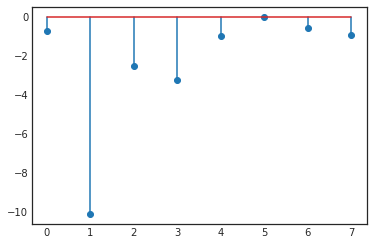

In [49]:
N1=X1.shape[0]
N2=X2.shape[0]
logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)

X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()
c=np.concatenate([X1_ecidx,X2_ecidx])
c=np.concatenate([np.ones((N1+N2,1)),c],axis=1)
logit = sm.Logit( logr_labels,c)


# fit the model
result = logit.fit()
print( result.summary())
print(result.wald_test_terms())
plt.stem(np.log(result.pvalues))

(3000, 342638)
(3000, 342638)
pval= 0.721686604101


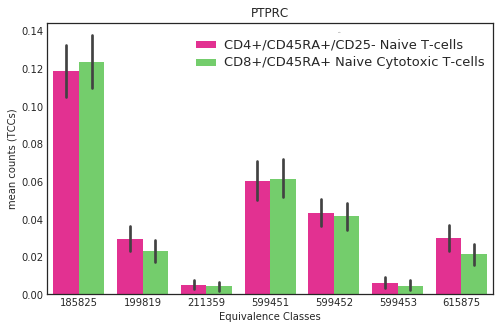

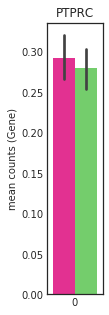

In [50]:
#positive control 

X1=X_naive[randperm1[:samples],:]
X2=X_cyto[randperm3[:samples],:]


print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()

Optimization terminated successfully.
         Current function value: 0.692772
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5992
Method:                           MLE   Df Model:                            7
Date:                Wed, 13 Dec 2017   Pseudo R-squ.:               0.0005414
Time:                        19:24:08   Log-Likelihood:                -4156.6
converged:                       True   LL-Null:                       -4158.9
                                        LLR p-value:                    0.7203
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.028     -0.193      0.847      -0.060       0.049
x1            -0.0283      0.

<Container object of 3 artists>

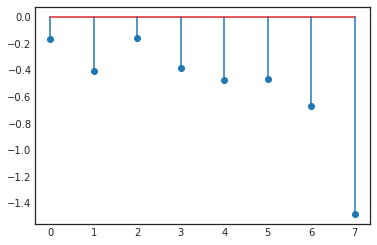

In [51]:
N1=X1.shape[0]
N2=X2.shape[0]
logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)

X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()
c=np.concatenate([X1_ecidx,X2_ecidx])
c=np.concatenate([np.ones((N1+N2,1)),c],axis=1)
logit = sm.Logit( logr_labels,c)


# fit the model
result = logit.fit()
print( result.summary())
print(result.wald_test_terms())
plt.stem(np.log(result.pvalues))

(3000, 342638)
(3000, 342638)
pval= 0.000279477161797


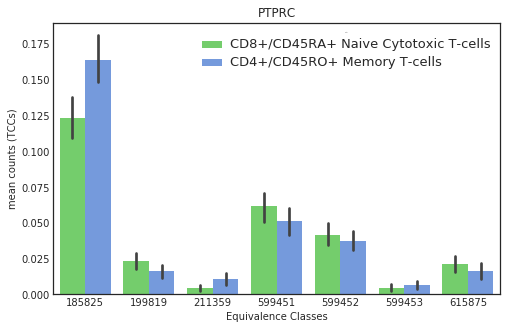

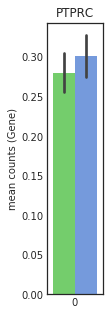

In [52]:
#positive control 

X1=X_cyto[randperm3[:samples],:]
X2=X_mem[randperm2[:samples],:]



print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c","#6495ED"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c","#6495ED"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()

Optimization terminated successfully.
         Current function value: 0.690856
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5992
Method:                           MLE   Df Model:                            7
Date:                Wed, 13 Dec 2017   Pseudo R-squ.:                0.003305
Time:                        19:24:10   Log-Likelihood:                -4145.1
converged:                       True   LL-Null:                       -4158.9
                                        LLR p-value:                 0.0002715
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0243      0.028      0.864      0.388      -0.031       0.079
x1            -0.2274      0.

<Container object of 3 artists>

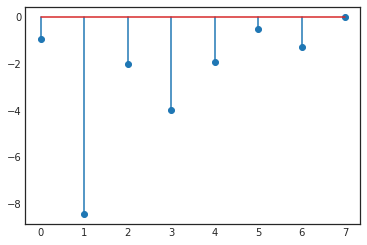

In [53]:
N1=X1.shape[0]
N2=X2.shape[0]
logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)

X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()
c=np.concatenate([X1_ecidx,X2_ecidx])
c=np.concatenate([np.ones((N1+N2,1)),c],axis=1)
logit = sm.Logit( logr_labels,c)


# fit the model
result = logit.fit()
print( result.summary())
print(result.wald_test_terms())
plt.stem(np.log(result.pvalues))

### cyto vs naive 

In [54]:
np.random.seed(0)
samples=3000
carlo=200
pvals=[]
for monte in range(carlo):
    randperm1A=np.random.permutation(X_naive.shape[0])
    randperm3A=np.random.permutation(X_cyto.shape[0])
    #positive control 

    X1=X_naive[randperm1A[:samples],:]
    X2=X_cyto[randperm3A[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    print(monte,'\t pval=',A[1])
    pvals+=[A[1]]
print("\nAvg. p-value: ",np.mean(pvals))
plt.show

0 	 pval= 0.57502595545
1 	 pval= 0.182891934467
2 	 pval= 0.000275740278191
3 	 pval= 0.62286083319
4 	 pval= 0.329662303252
5 	 pval= 0.237910558381
6 	 pval= 0.191319245992
7 	 pval= 0.0398166322359
8 	 pval= 0.561442597614
9 	 pval= 0.734113212134
10 	 pval= 0.0502402619813
11 	 pval= 0.00137573052064
12 	 pval= 0.0622199189745
13 	 pval= 0.476208198894
14 	 pval= 0.237836407913
15 	 pval= 8.21562599164e-05
16 	 pval= 0.0389081737081
17 	 pval= 0.0318180455611
18 	 pval= 0.0501854383593
19 	 pval= 0.0570834618479
20 	 pval= 0.00136772306564
21 	 pval= 0.348085520453
22 	 pval= 0.251093617964
23 	 pval= 0.337157782366
24 	 pval= 0.236688337201
25 	 pval= 0.115199837196
26 	 pval= 0.267613429275
27 	 pval= 0.0768357905177
28 	 pval= 0.1860217088
29 	 pval= 0.241850409684
30 	 pval= 0.000777811905698
31 	 pval= 0.118279250243
32 	 pval= 0.0283759259604
33 	 pval= 0.0321415336815
34 	 pval= 0.0767227922169
35 	 pval= 0.0279404400005
36 	 pval= 0.3746600114
37 	 pval= 0.045944199679
38 

<function matplotlib.pyplot.show>

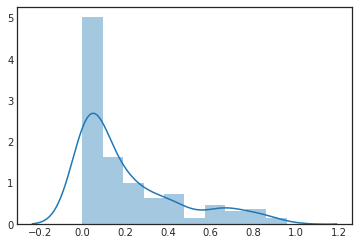

In [55]:
sns.distplot(np.array(pvals))

### mem vs naive

In [56]:
np.random.seed(0)
samples=3000
carlo=200
pvals=[]
for monte in range(carlo):
    randperm1A=np.random.permutation(X_naive.shape[0])
    randperm2A=np.random.permutation(X_mem.shape[0])
    #positive control 

    X1=X_naive[randperm1A[:samples],:]
    X2=X_mem[randperm2A[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    print(monte,'\t pval=',A[1])
    pvals+=[A[1]]
print("\nAvg. p-value: ",np.mean(pvals))

0 	 pval= 9.16495524228e-06
1 	 pval= 3.87627588894e-06
2 	 pval= 0.000466436201409
3 	 pval= 0.000158313392895
4 	 pval= 7.54624292283e-05
5 	 pval= 0.0931362322678
6 	 pval= 1.01091023885e-07
7 	 pval= 0.000166160097244
8 	 pval= 0.00542455676469
9 	 pval= 1.83447000514e-05
10 	 pval= 0.00853979622645
11 	 pval= 0.00116043290663
12 	 pval= 7.39992133351e-05
13 	 pval= 4.44127039012e-06
14 	 pval= 1.247889011e-05
15 	 pval= 0.00297050196488
16 	 pval= 8.2603578041e-06
17 	 pval= 0.00122699083474
18 	 pval= 0.000115137130519
19 	 pval= 0.00143263145769
20 	 pval= 5.39744296657e-06
21 	 pval= 3.07769828956e-07
22 	 pval= 3.95331598679e-07
23 	 pval= 0.000240257256378
24 	 pval= 1.100820057e-06
25 	 pval= 2.88107270707e-07
26 	 pval= 2.96431821136e-05
27 	 pval= 3.9606360956e-05
28 	 pval= 0.000360151229
29 	 pval= 0.00519041846011
30 	 pval= 0.000151575938551
31 	 pval= 0.000270417728507
32 	 pval= 1.02355500318e-05
33 	 pval= 6.32134013975e-05
34 	 pval= 6.17033473278e-05
35 	 pval= 0.

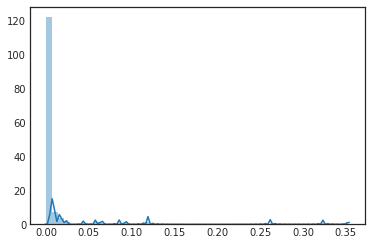

In [ ]:
sns.distplot(np.array(pvals))

### cyto vs mem

In [ ]:
np.random.seed(0)
samples=3000
carlo=200
pvals=[]

for monte in range(carlo):
    randperm3A=np.random.permutation(X_cyto.shape[0])
    randperm2A=np.random.permutation(X_mem.shape[0])
    #positive control 

    X1=X_cyto[randperm3A[:samples],:]
    X2=X_mem[randperm2A[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    print(monte,'\t pval=',A[1])
    pvals+=[A[1]]
print("\nAvg. p-value: ",np.mean(pvals))

0 	 pval= 2.7329784812e-05
1 	 pval= 0.000356287208646
2 	 pval= 5.12281411841e-05
3 	 pval= 0.000356377828727
4 	 pval= 1.53036893802e-06
5 	 pval= 1.62583747447e-05
6 	 pval= 0.000178974771578
7 	 pval= 0.0343573340429
8 	 pval= 0.0135550870034
9 	 pval= 8.89168079304e-05
10 	 pval= 0.013910915357
11 	 pval= 7.46159332765e-07
12 	 pval= 0.000151450718116
13 	 pval= 3.35001938827e-05
14 	 pval= 0.0205115980048
15 	 pval= 0.000106779144138
16 	 pval= 3.98122432799e-08
17 	 pval= 0.00107198151415
18 	 pval= 0.000178150586012
19 	 pval= 3.38527213252e-05
20 	 pval= 0.00246558367692
21 	 pval= 0.00131742489994
22 	 pval= 0.0284744250364
23 	 pval= 1.29386907066e-06
24 	 pval= 0.000124593369538
25 	 pval= 1.64614665118e-05
26 	 pval= 0.0164725747964
27 	 pval= 1.60004956962e-06
28 	 pval= 0.00191406153206
29 	 pval= 0.00331005302187
30 	 pval= 3.49044318393e-06
31 	 pval= 8.65701190259e-05
32 	 pval= 0.000362107691391
33 	 pval= 0.000979327961675
34 	 pval= 0.0255715962632
35 	 pval= 5.423

In [ ]:
sns.distplot(np.array(pvals))

## Explore all genes for ec DE

In [59]:
def logr_ecidx(ecidx,X1,X2):
    
    N1=X1.shape[0]
    N2=X2.shape[0]
    logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
    logr = LogisticRegression()
    p_of_1=N1/float(N1+N2)
    llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
    k=len(ecidx)
    
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()
    c=np.concatenate([X1_ecidx,X2_ecidx])
    #c=np.concatenate([X1[:,ecidx],X2[:,ecidx]])
    logr.fit(c,logr_labels)
    pred=np.array(logr.predict_proba(c)[:,1])
    gene_score=log_loss(logr_labels,pred)
    llf=-gene_score*(N1+N2)
    llr=llf-llnull
    llr_pval = 1-stats.chi2.cdf(2*llr,k)
    
    return [logr,llr_pval]

In [60]:
gnames=np.unique(np.array(list(all_gene_names_to_id.keys())))
print(len(gnames))

24007


## Naive vs Memory

In [61]:
X_naive=X[np.squeeze(labels==0),:]
X_mem=X[np.squeeze(labels==1),:]
# X_cyto=X[np.squeeze(labels==2),:]

### random seed 1

In [62]:
samp = 4000

np.random.seed(1)
randperm1=np.random.permutation(X_naive.shape[0])
randperm2=np.random.permutation(X_mem.shape[0])
# randperm3=np.random.permutation(X_cyto.shape[0])

X_n = X_naive[randperm1[:samp],:]
X_m = X_mem[randperm2[:samp],:]
# X_c = X_cyto[randperm3[:samp],:]

['AES']
	 GENE_pval:  0.36851290067
	 LogR pval:  1.69362955049e-06


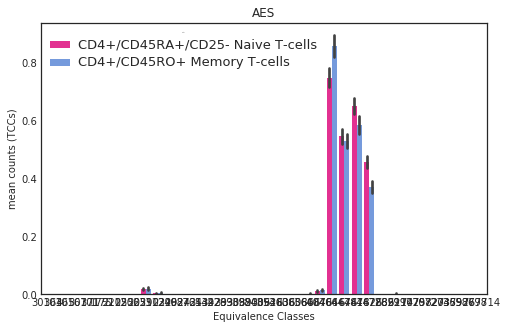

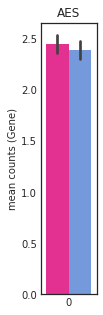

['ANAPC16']
	 GENE_pval:  0.406023191074
	 LogR pval:  1.73794867941e-07


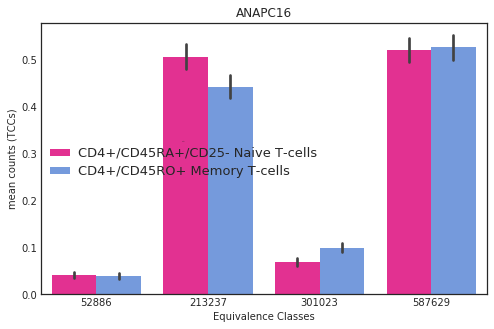

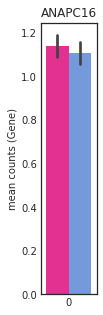

['ANAPC5']
	 GENE_pval:  0.208379969187
	 LogR pval:  0.00111858983068


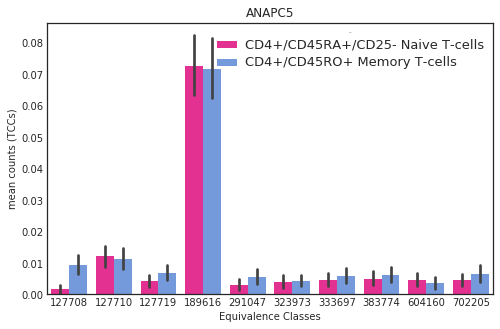

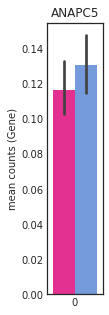

['ATP5A1']
	 GENE_pval:  0.24909241297
	 LogR pval:  4.80134598746e-10


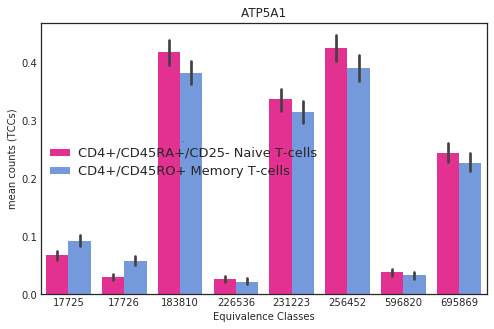

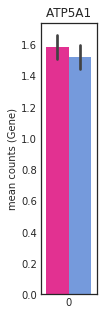

['C12orf65']
	 GENE_pval:  0.303431885651
	 LogR pval:  0.000183028946255


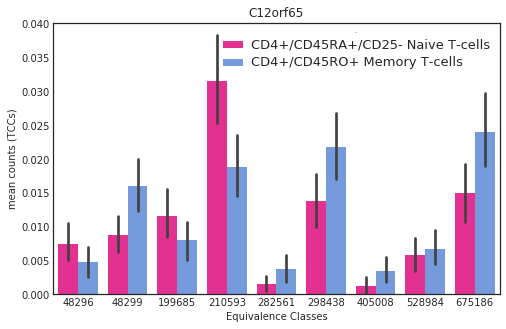

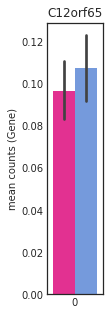

['CALM3']
	 GENE_pval:  0.42624723666
	 LogR pval:  0.0


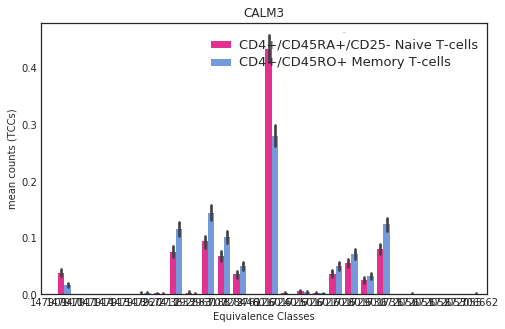

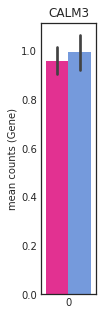

['CCDC59']
	 GENE_pval:  0.487939407771
	 LogR pval:  0.000816035381472


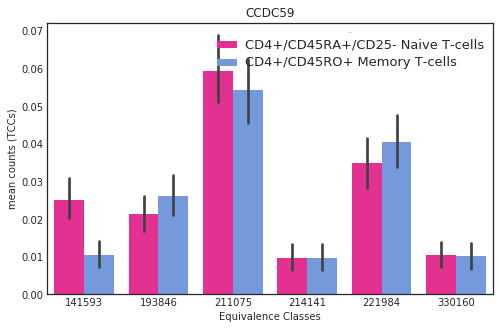

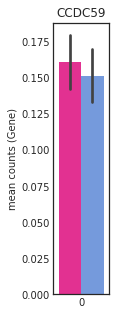

['CCT2']
	 GENE_pval:  0.372837670382
	 LogR pval:  1.03164042431e-06


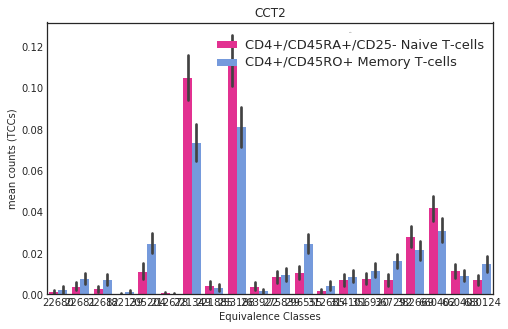

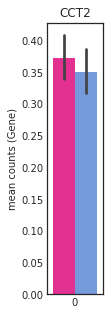

['CD46']
	 GENE_pval:  0.566079186522
	 LogR pval:  0.00107230980156


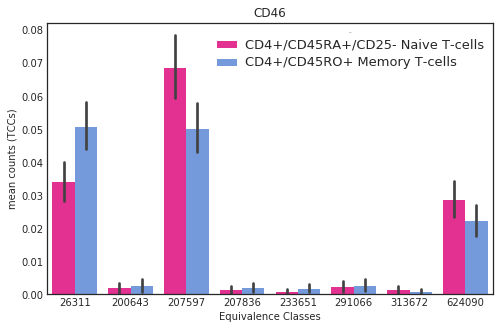

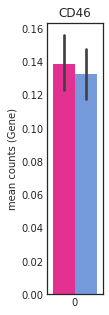

['CDC42SE2']
	 GENE_pval:  0.931591293074
	 LogR pval:  9.23911347983e-07


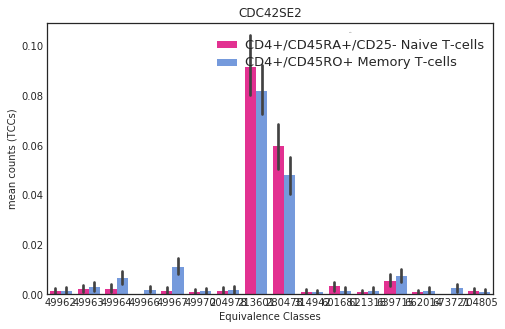

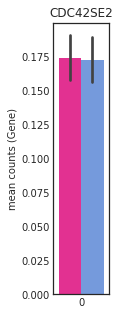

['CHCHD7']
	 GENE_pval:  0.401876432049
	 LogR pval:  3.78319024219e-07


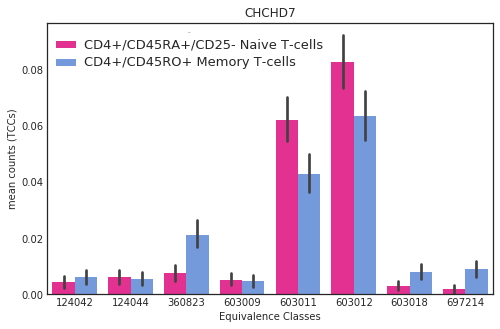

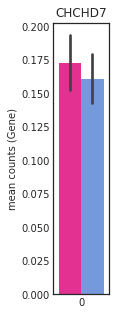

['DCAF11']
	 GENE_pval:  0.784533132658
	 LogR pval:  0.000281940211779


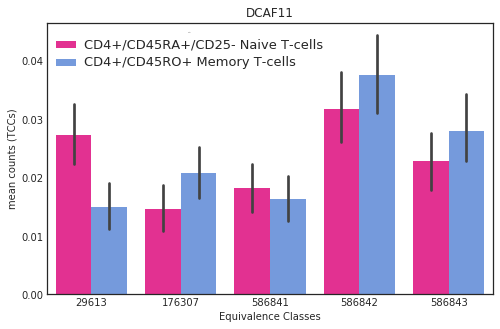

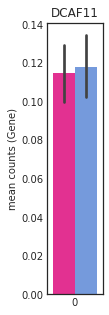

['DDX17']
	 GENE_pval:  0.545318395105
	 LogR pval:  3.09963166245e-11


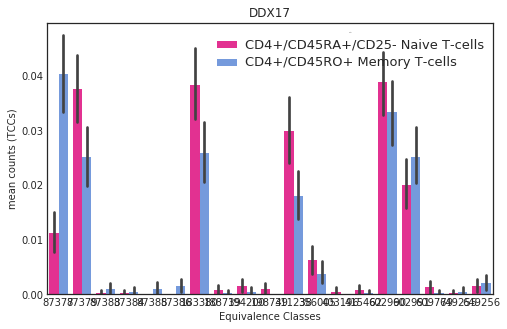

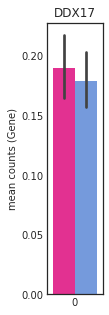

['DNAJC8']
	 GENE_pval:  0.284919012012
	 LogR pval:  1.5779424678e-07


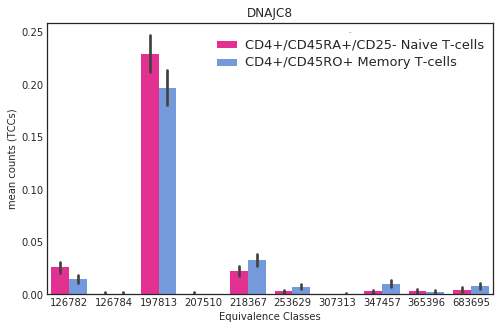

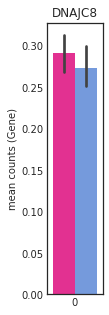

['EAPP']
	 GENE_pval:  0.409356645491
	 LogR pval:  0.00450362590745


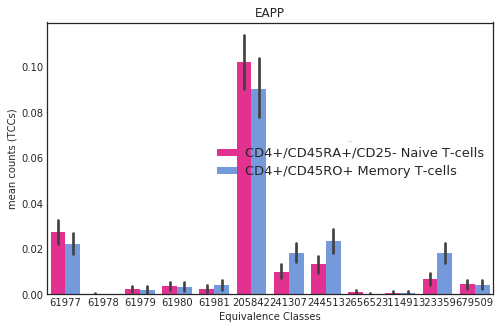

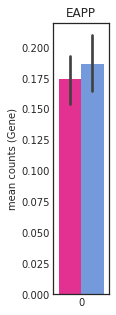

['ECHDC1']
	 GENE_pval:  0.284172076486
	 LogR pval:  0.0015297371418


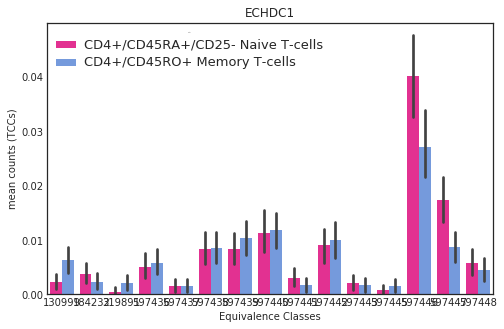

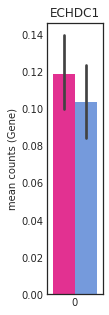

['EIF4B']
	 GENE_pval:  0.755000920312
	 LogR pval:  2.82465765965e-05


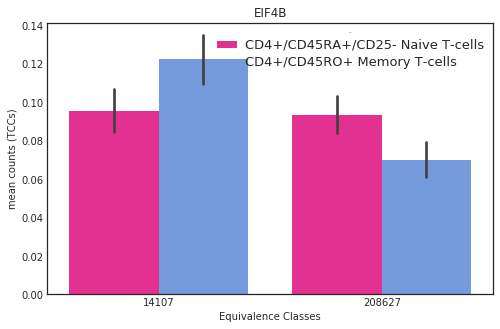

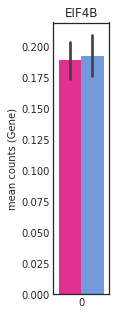

['FLAD1']
	 GENE_pval:  0.581056304805
	 LogR pval:  8.09158478985e-05


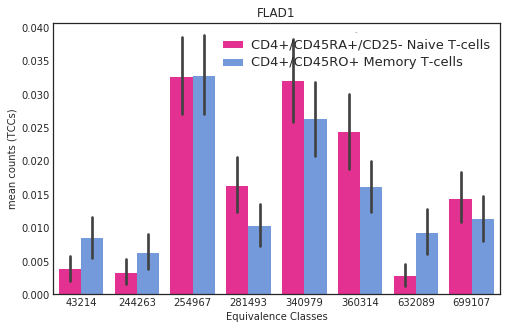

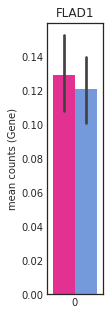

['GIMAP4']
	 GENE_pval:  0.388814940709
	 LogR pval:  0.000255562132132


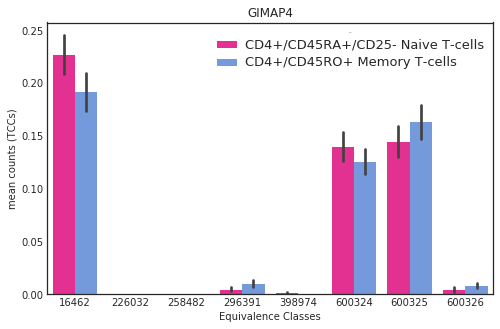

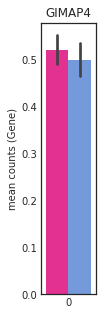

['LEPROTL1']
	 GENE_pval:  0.230459648709
	 LogR pval:  1.25714121335e-08


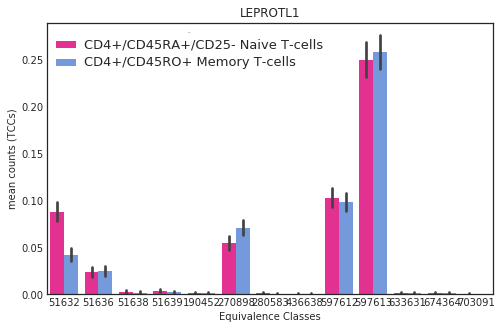

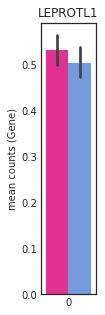

['MBNL1']
	 GENE_pval:  0.511977569257
	 LogR pval:  2.67008637422e-13


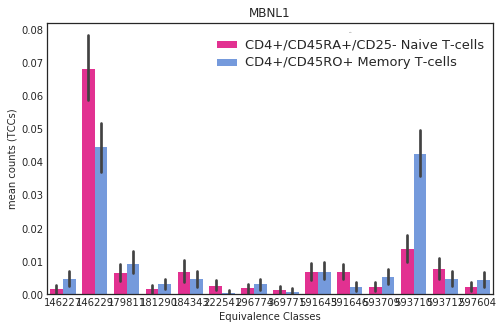

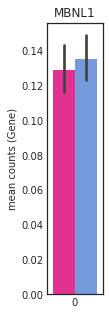

['MGAT4A']
	 GENE_pval:  0.299551329222
	 LogR pval:  2.20898546031e-05


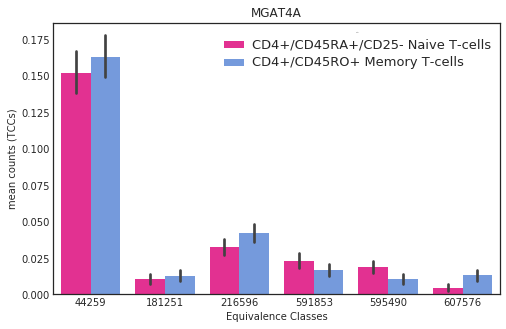

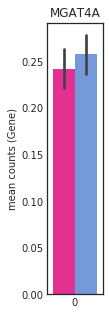

['MRPS7']
	 GENE_pval:  0.709216012282
	 LogR pval:  0.00486425281316


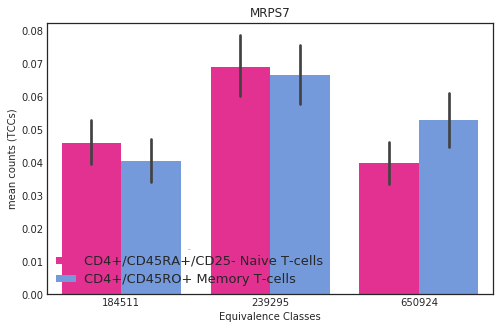

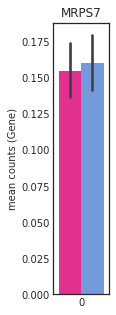

['MTERF4']
	 GENE_pval:  1.0
	 LogR pval:  6.54374374337e-05


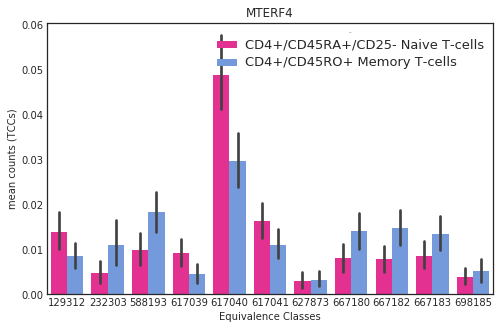

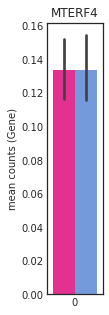

['MTMR14']
	 GENE_pval:  0.440872044843
	 LogR pval:  0.00229451838593


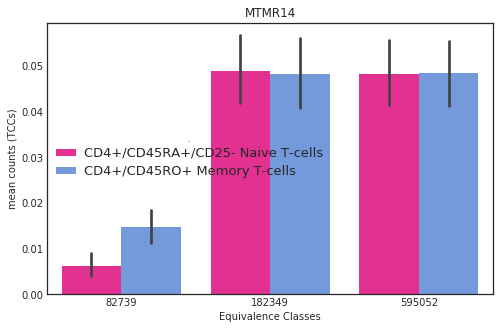

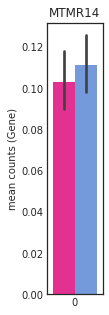

['NCBP2']
	 GENE_pval:  0.560241126308
	 LogR pval:  0.000708536480818


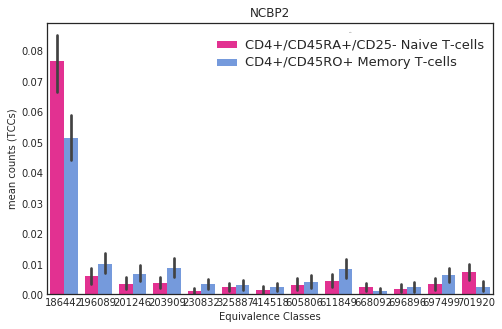

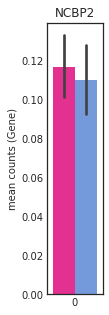

['NIFK']
	 GENE_pval:  0.455846849246
	 LogR pval:  0.00256929950351


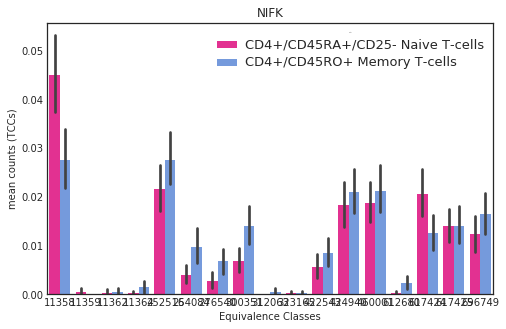

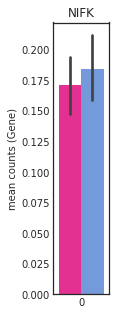

['PEX16']
	 GENE_pval:  0.280219390528
	 LogR pval:  0.00430212315013


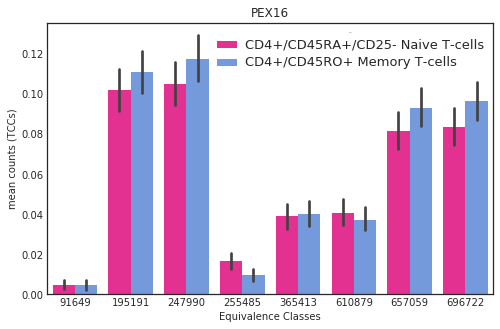

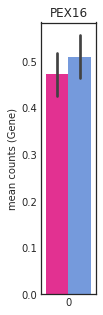

['PRKCA']
	 GENE_pval:  0.246571871986
	 LogR pval:  0.000132970610788


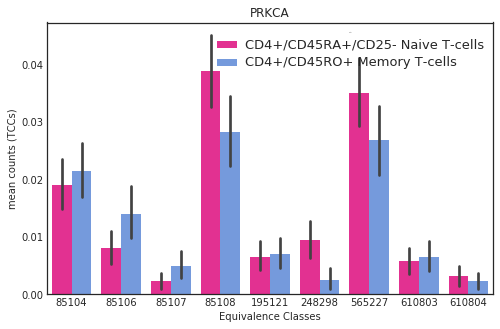

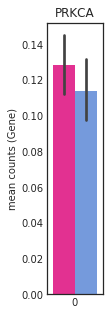

['PTPRC']
	 GENE_pval:  0.536184902985
	 LogR pval:  0.00100209971109


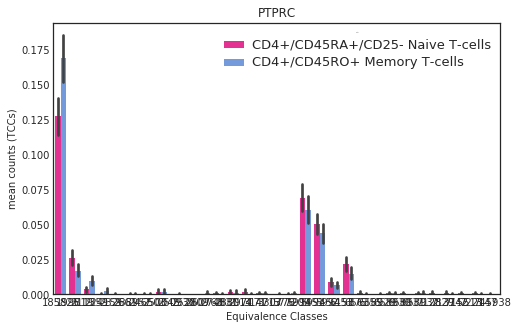

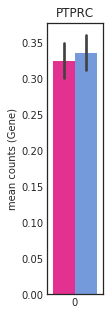

['RAB7A']
	 GENE_pval:  0.269774526043
	 LogR pval:  0.00152257505365


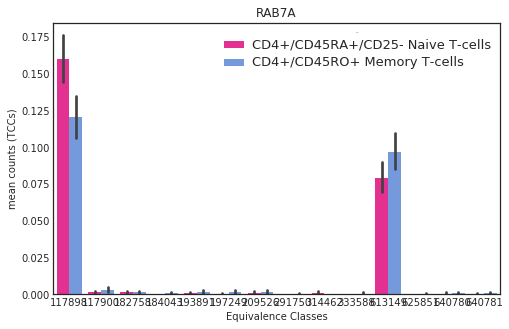

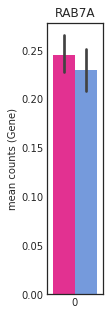

['RPUSD3']
	 GENE_pval:  0.306425773161
	 LogR pval:  0.00144799058943


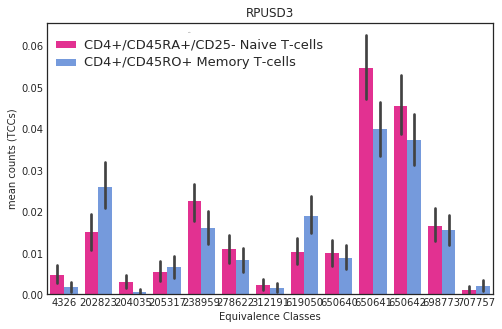

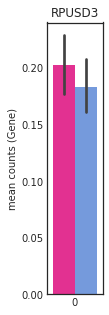

['SEPT7']
	 GENE_pval:  0.206477679471
	 LogR pval:  1.11022302463e-16


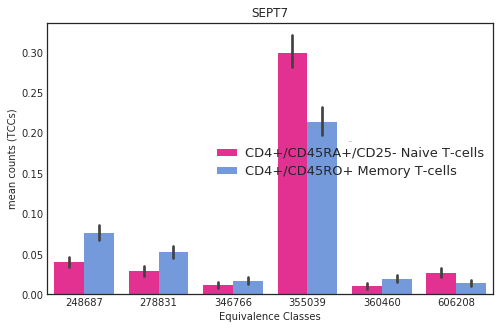

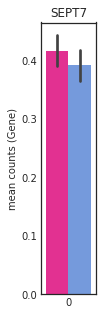

['SERBP1']
	 GENE_pval:  0.269873330882
	 LogR pval:  2.9052784789e-06


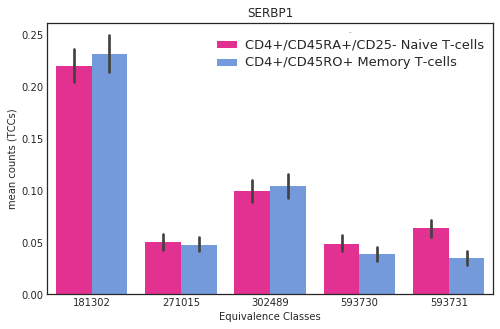

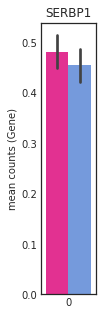

['SMIM7']
	 GENE_pval:  0.305810216901
	 LogR pval:  1.46491732078e-08


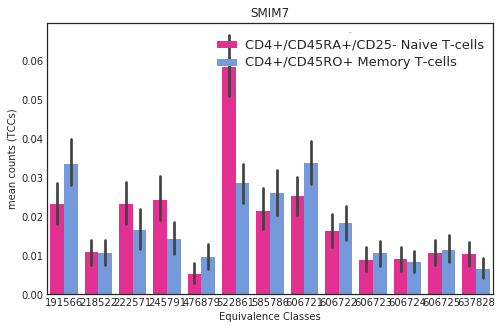

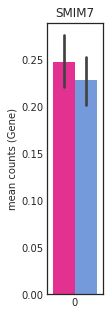

['SRSF3']
	 GENE_pval:  0.347537549706
	 LogR pval:  5.68687693825e-07


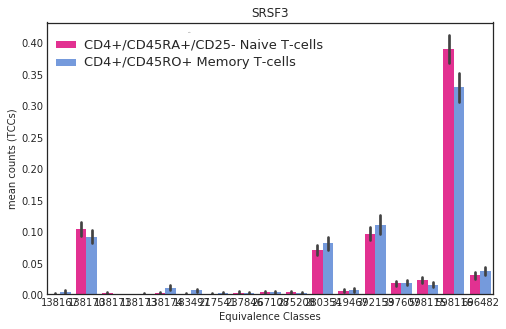

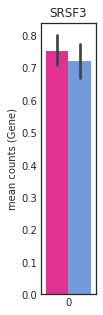

['SRSF5']
	 GENE_pval:  0.268549318254
	 LogR pval:  3.66373598126e-15


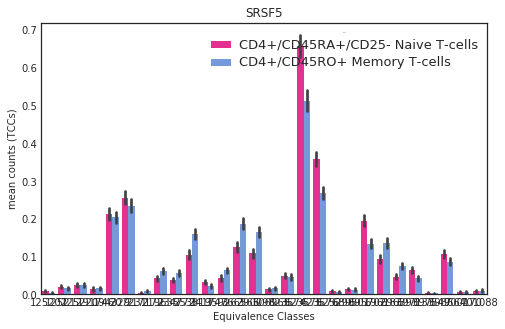

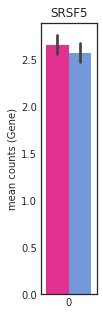

['SSR1']
	 GENE_pval:  0.580517918469
	 LogR pval:  2.38817653384e-05


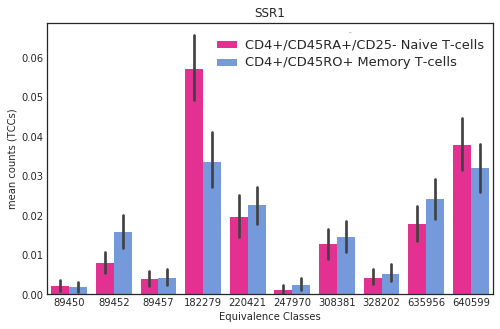

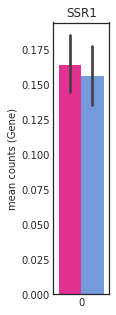

['SSR2']
	 GENE_pval:  0.853503374998
	 LogR pval:  6.26519177649e-08


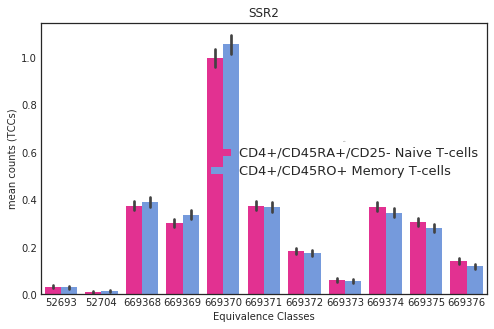

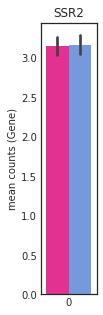

['TAF1D']
	 GENE_pval:  0.420043873617
	 LogR pval:  0.000105605978142


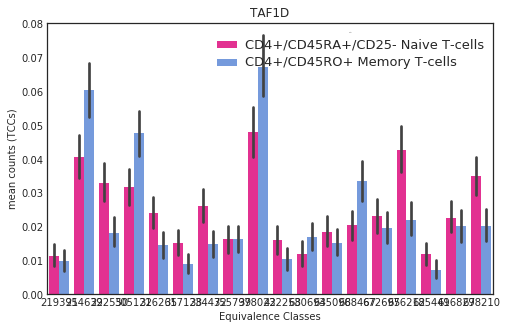

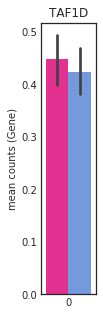

['TAGAP']
	 GENE_pval:  0.438870673229
	 LogR pval:  7.74734708608e-08


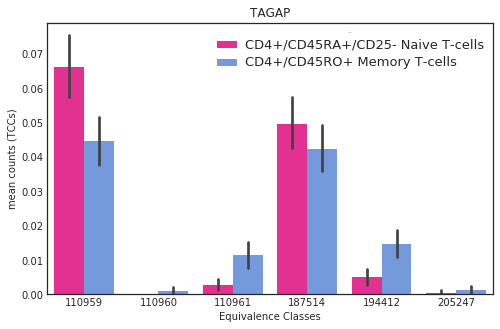

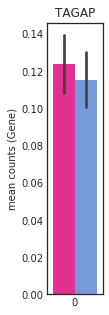

['TMBIM6']
	 GENE_pval:  0.34955826869
	 LogR pval:  0.0


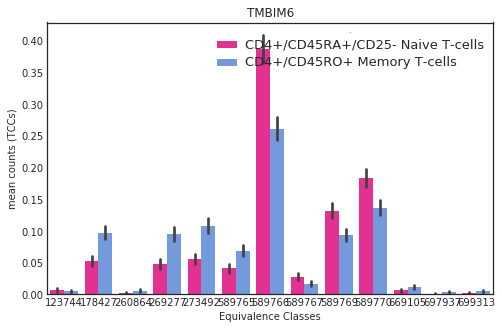

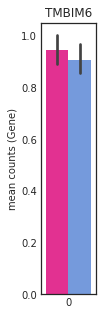

['TRAM1']
	 GENE_pval:  0.571334670225
	 LogR pval:  0.000494024863437


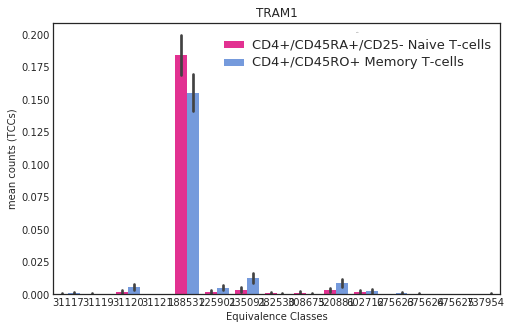

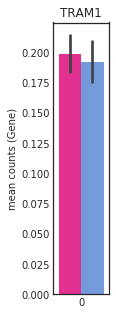

['TSN']
	 GENE_pval:  0.239262929569
	 LogR pval:  0.000359606017005


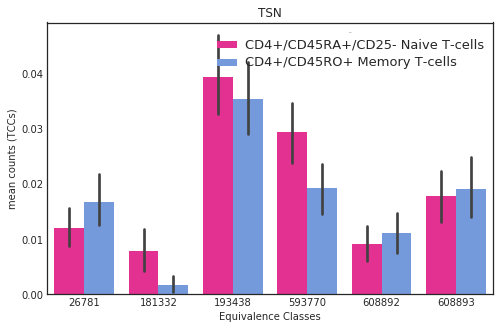

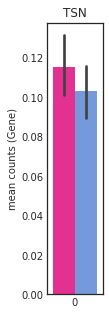

['TTC1']
	 GENE_pval:  0.275071296032
	 LogR pval:  0.00464927993939


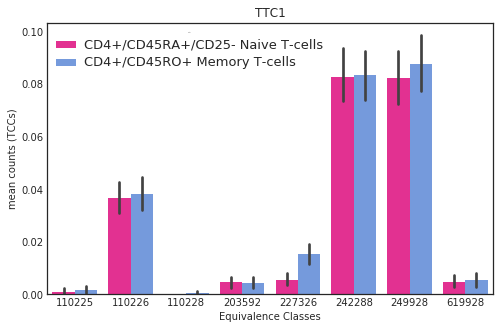

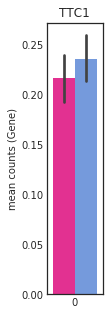

['VAMP2']
	 GENE_pval:  0.540441064161
	 LogR pval:  0.00178325762705


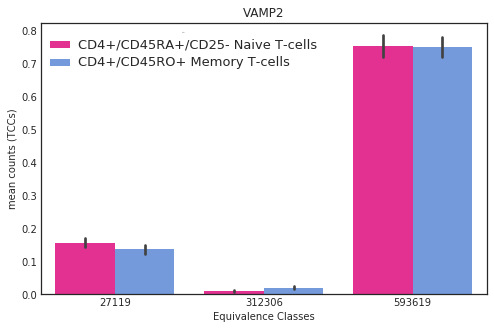

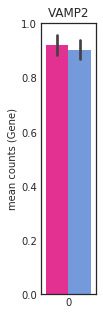

['XBP1']
	 GENE_pval:  0.644363200738
	 LogR pval:  2.40518716055e-12


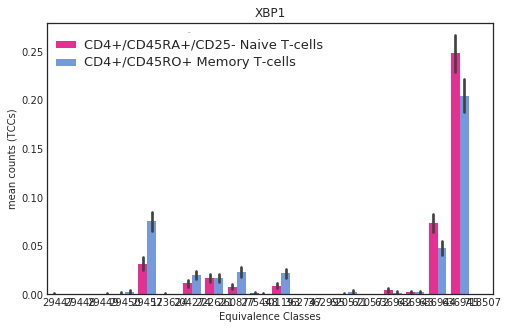

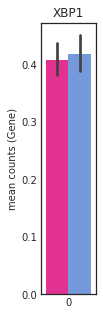

['ZNF331']
	 GENE_pval:  0.504639404352
	 LogR pval:  0.00185443617845


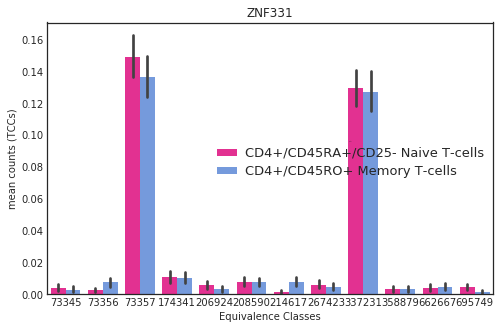

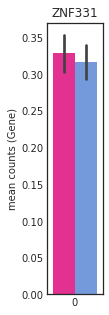

['ZRANB2']
	 GENE_pval:  0.629410474943
	 LogR pval:  0.000712809760741


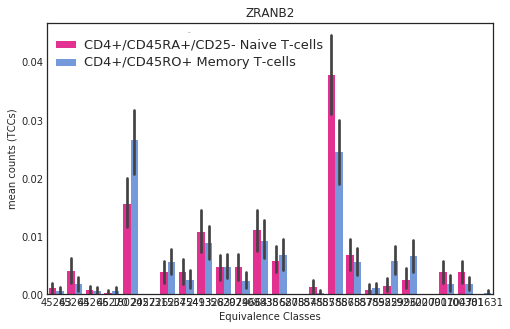

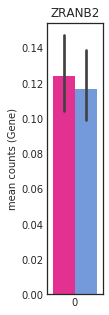

CPU times: user 36min 38s, sys: 2min 18s, total: 38min 57s
Wall time: 9min 4s


In [63]:
%%time
for gene in gnames:

    gene_ecs0=[]
    for g in all_gene_names_to_id[gene]:
        gene_ecs0+=ENSG_EC_DICT[g]
    gene_ecs0=np.unique(gene_ecs0)

    ec_counts=[]
    for ec in gene_ecs0:
        ec_counts+=[T[EC_IDX[ec],:].sum()]

    argsrt=np.argsort(ec_counts)[::-1]

    firstk=1
    gene_ecs = gene_ecs0[argsrt[:firstk]]
    associated_genes=[]
    for ec in gene_ecs:
        associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
    associated_genes=np.unique(associated_genes)

    while len(associated_genes)==1:
        firstk=firstk+1
        if firstk==len(argsrt)+1: break
        gene_ecs = gene_ecs0[argsrt[:firstk]]
        associated_genes=[]
        for ec in gene_ecs:
            associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
        associated_genes=np.unique(associated_genes)
        
    if firstk>1:firstk-=1
    gene_ecs=gene_ecs0[argsrt[:firstk]]
    if len(gene_ecs)>0:
        associated_genes=[]
        for ec in gene_ecs:
            associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
        associated_genes=np.unique(associated_genes)
    if len(associated_genes)==1:
        ecidx=np.array([EC_IDX[ec] for ec in gene_ecs])
        Gexp_n = np.array(X_n[:,ecidx].todense().T.sum(axis=0))[0]
        Gexp_m = np.array(X_m[:,ecidx].todense().T.sum(axis=0))[0]
#         Gexp_c = np.array(X_c[:,ecidx].todense().T.sum(axis=0))[0]
        if 0.5*(np.mean(Gexp_n)+np.mean(Gexp_m))>0.1:
            N1=samp
            N2=samp
            logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
            logrG = LogisticRegression()
            p_of_1=N1/float(N1+N2)
            llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
            k=1
            c=np.concatenate([Gexp_n,Gexp_m]).reshape(-1, 1)
            logrG.fit(c,logr_labels)
            pred=np.array(logrG.predict_proba(c)[:,1])
            gene_score=log_loss(logr_labels,pred)
            llf=-gene_score*(N1+N2)
            llr=llf-llnull
            llr_pval = 1-stats.chi2.cdf(2*llr,k)
            if llr_pval>0.2:
                A=logr_ecidx(ecidx, X_n,X_m)
                if A[1]<0.005:
                    print(associated_genes)
                    print("\t GENE_pval: ",llr_pval)
                    print("\t LogR pval: ",A[1])
                    P1=pd.DataFrame(X_n[:,ecidx].todense(),columns=nonzero_ec[ecidx])
                    P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
                    P2=pd.DataFrame(X_m[:,ecidx].todense(),columns=nonzero_ec[ecidx])
                    P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
                    P=P1.append(P2)
                    df = pd.melt(P,  id_vars='cluster')

                    plt.figure(figsize=(8,5))
                    ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493","#6495ED"], data=df)
                    ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
                    plt.title(associated_genes[0])
                    plt.setp(ax.get_legend().get_texts(), fontsize='13') 
                    plt.setp(ax.get_legend().get_title(), fontsize='0')
                    plt.show()




                    P1=pd.DataFrame(Gexp_n.T,)
                    P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
                    P2=pd.DataFrame(Gexp_m.T)
                    P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
                    P=P1.append(P2)
                    df = pd.melt(P,  id_vars='cluster')

                    plt.figure(figsize=(1,5))
                    ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493","#6495ED"], data=df)
                    ax.set(xlabel='', ylabel='mean counts (Gene)')
                    ax.legend_.remove()
                    plt.title(associated_genes[0])
                    plt.show()


        
        
    

# clean_ecs=np.unique(clean_ecs)

### random seed 2

In [64]:
samp = 4000

np.random.seed(2)
randperm1=np.random.permutation(X_naive.shape[0])
randperm2=np.random.permutation(X_mem.shape[0])
# randperm3=np.random.permutation(X_cyto.shape[0])

X_n = X_naive[randperm1[:samp],:]
X_m = X_mem[randperm2[:samp],:]
# X_c = X_cyto[randperm3[:samp],:]

['ALDOA']
	 GENE_pval:  0.907970414674
	 LogR pval:  0.00479525377474


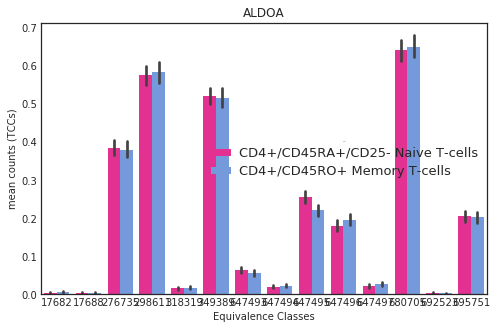

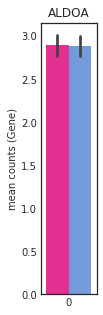

['ARF4']
	 GENE_pval:  0.543110084793
	 LogR pval:  0.000366759704967


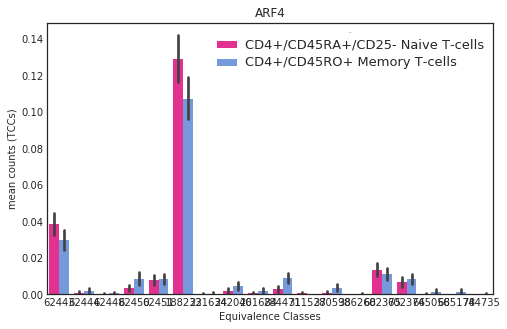

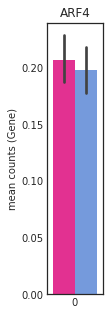

['ATM']
	 GENE_pval:  0.491113085697
	 LogR pval:  0.00382759316896


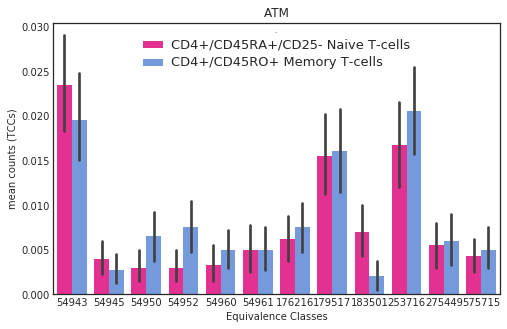

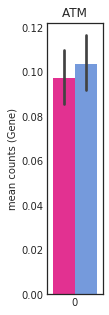

['ATP5A1']
	 GENE_pval:  0.707428223605
	 LogR pval:  4.17123446894e-10


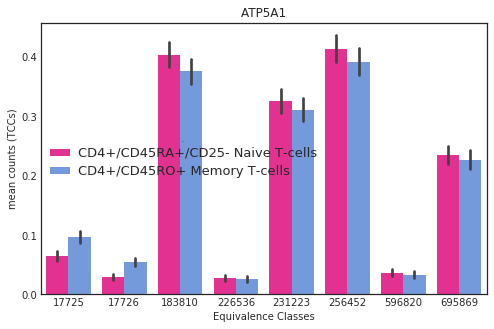

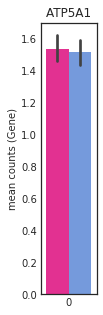

['C11orf58']
	 GENE_pval:  0.365591396396
	 LogR pval:  0.00489360705491


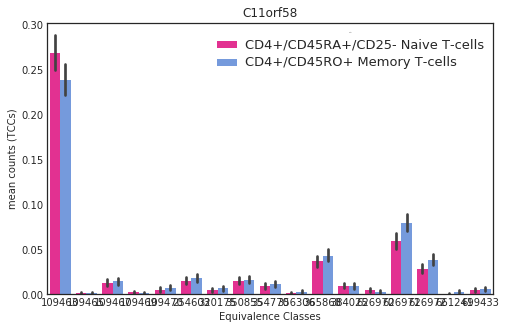

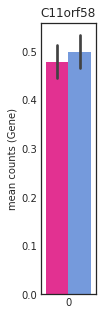

['C12orf65']
	 GENE_pval:  0.522713824087
	 LogR pval:  2.59176143993e-05


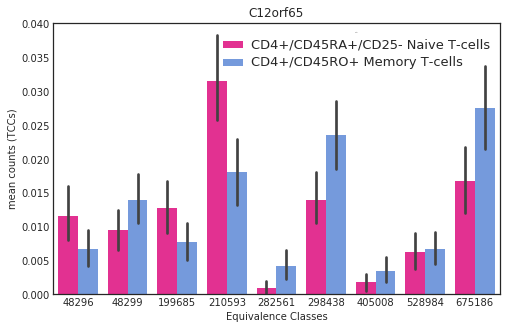

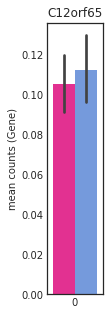

['CALM3']
	 GENE_pval:  0.732075431912
	 LogR pval:  0.0


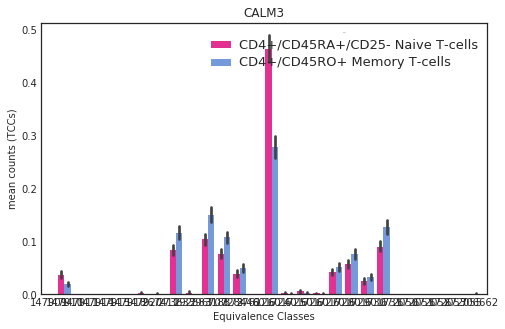

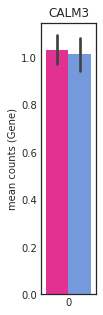

['CD46']
	 GENE_pval:  0.234332833399
	 LogR pval:  3.03293247517e-07


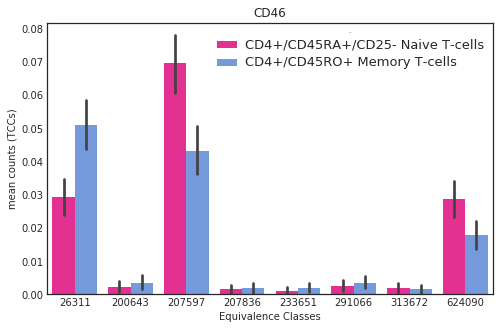

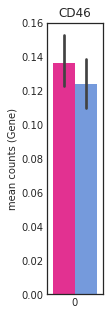

['CDC42SE2']
	 GENE_pval:  0.634929777036
	 LogR pval:  2.08617489659e-05


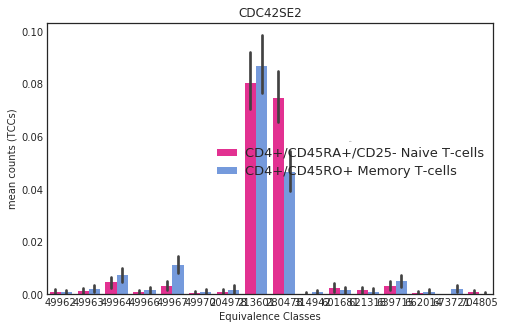

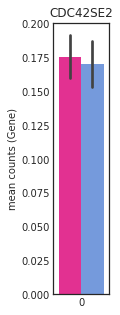

['CGGBP1']
	 GENE_pval:  0.303106637302
	 LogR pval:  0.00485255768878


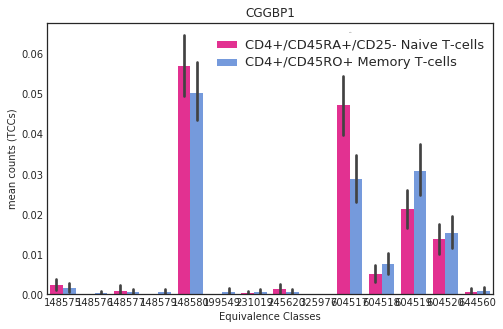

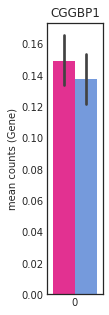

['DDX17']
	 GENE_pval:  0.901733986067
	 LogR pval:  3.67151180569e-08


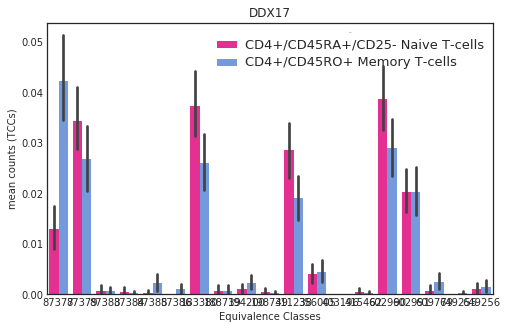

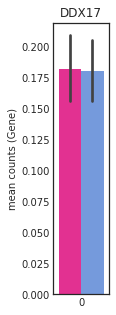

['DNAJB6']
	 GENE_pval:  0.545510488364
	 LogR pval:  0.00274505063788


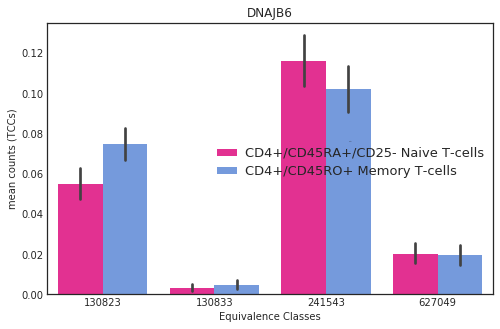

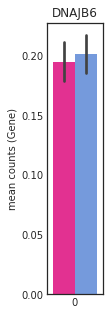

['DNAJC8']
	 GENE_pval:  0.91649305487
	 LogR pval:  6.11801787009e-09


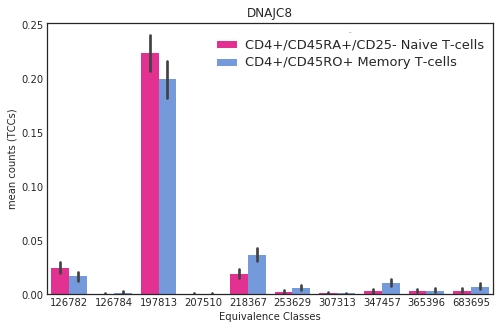

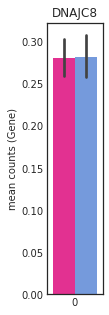

['ECHDC1']
	 GENE_pval:  0.928712992045
	 LogR pval:  0.000169117533106


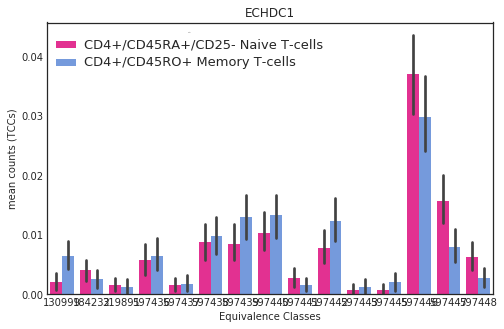

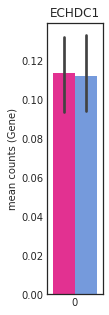

['ECHDC2']
	 GENE_pval:  0.249162273294
	 LogR pval:  3.91629135252e-05


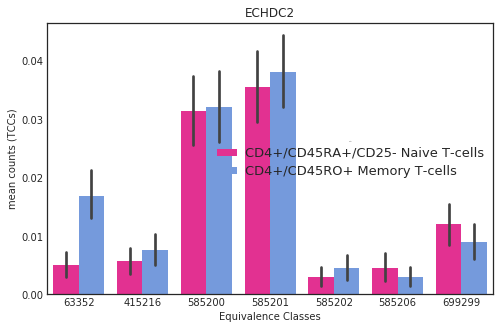

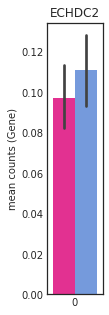

['EIF3G']
	 GENE_pval:  0.715219516038
	 LogR pval:  0.00250939120617


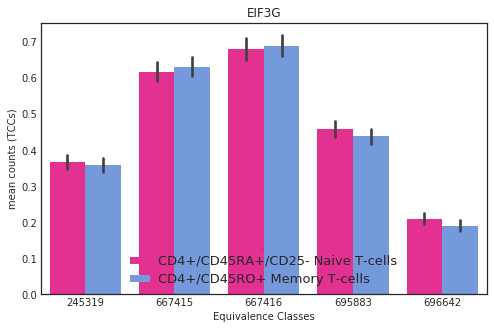

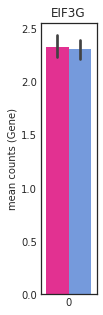

['EIF4B']
	 GENE_pval:  0.318203598414
	 LogR pval:  4.17829338906e-08


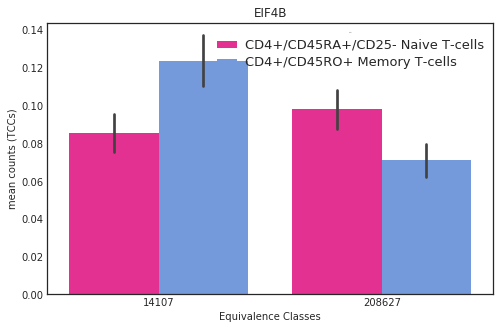

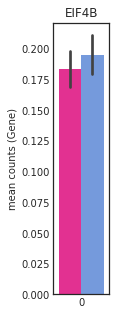

['FOXN3']
	 GENE_pval:  0.808841953661
	 LogR pval:  3.12164973042e-05


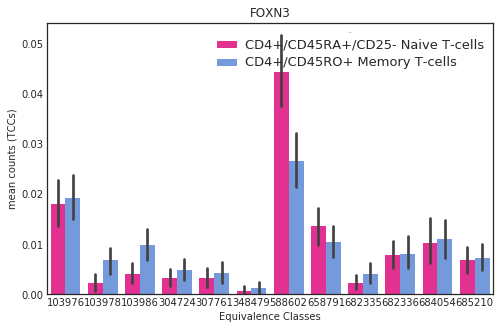

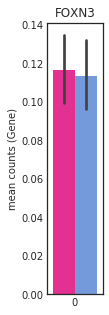

['FYB1']
	 GENE_pval:  0.710729890364
	 LogR pval:  0.000207129827329


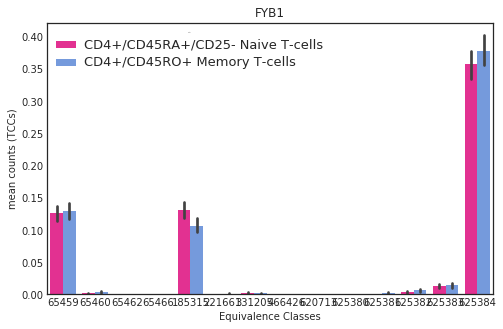

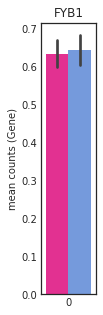

['GIMAP4']
	 GENE_pval:  0.432707950425
	 LogR pval:  1.00055315477e-07


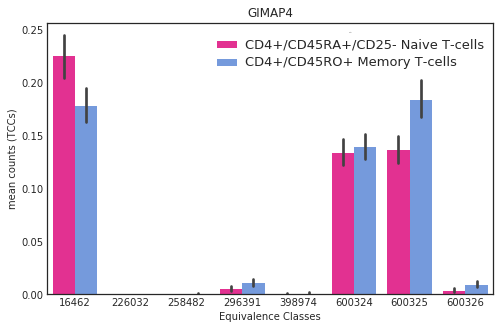

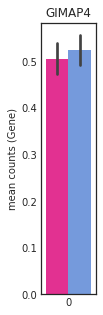

['HNRNPA3']
	 GENE_pval:  0.435930133311
	 LogR pval:  7.49934161425e-05


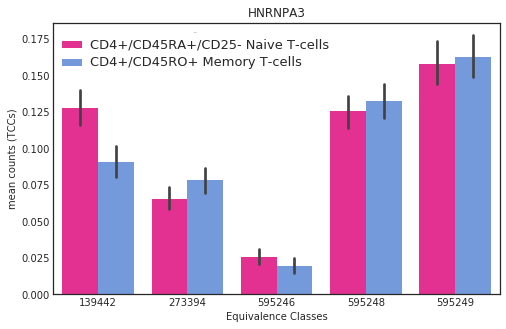

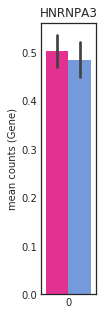

['HNRNPF']
	 GENE_pval:  0.666088575116
	 LogR pval:  0.000577120119063


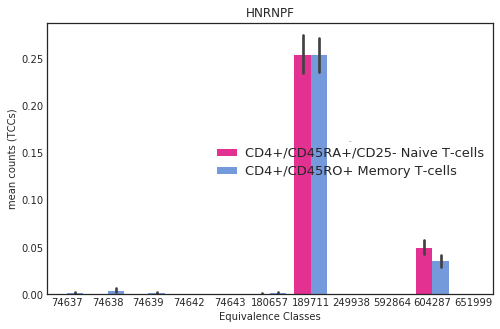

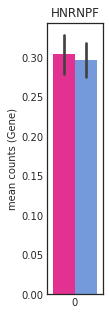

['LBH']
	 GENE_pval:  0.200542628962
	 LogR pval:  3.62814411847e-09


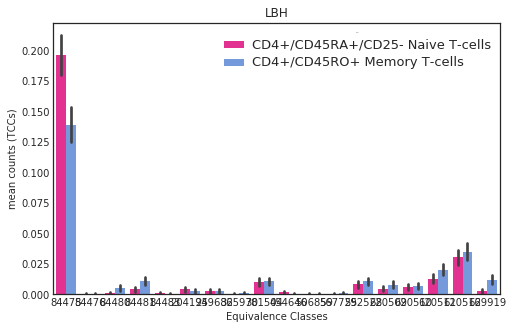

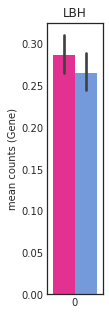

['MBNL1']
	 GENE_pval:  0.460016621305
	 LogR pval:  7.77156117238e-16


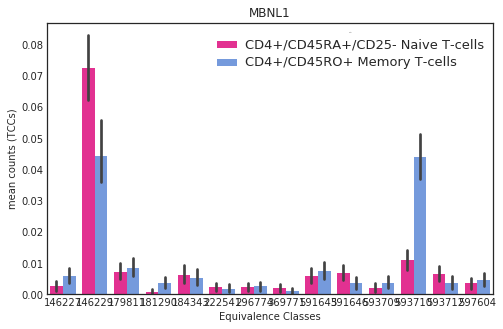

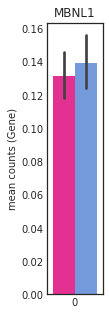

['MED4']
	 GENE_pval:  0.281268027142
	 LogR pval:  0.00372278655068


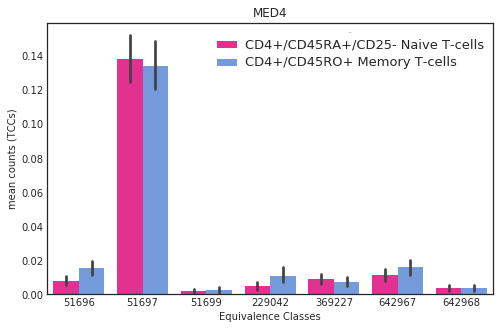

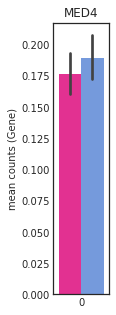

['MGAT4A']
	 GENE_pval:  0.495325553303
	 LogR pval:  0.00466061010511


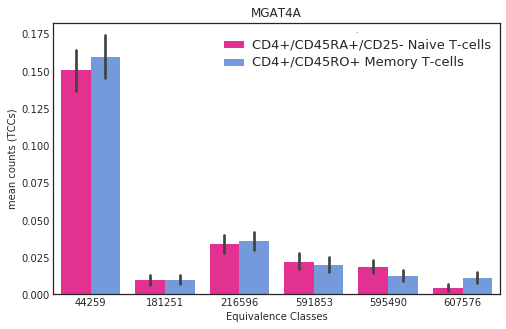

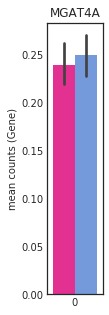

['MTERF4']
	 GENE_pval:  0.98539147725
	 LogR pval:  0.000368978754209


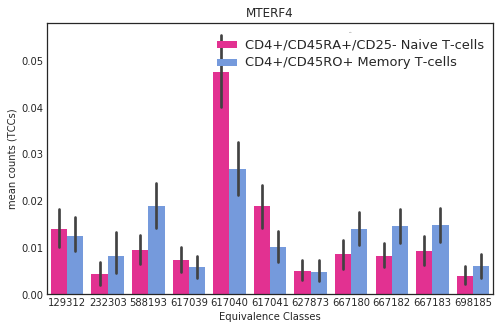

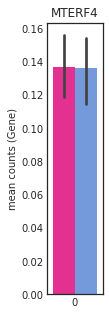

['N4BP2L2']
	 GENE_pval:  0.880693767719
	 LogR pval:  0.000352258281614


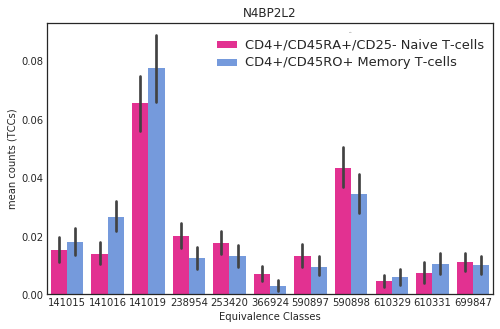

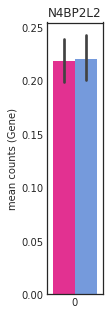

['NCBP2']
	 GENE_pval:  0.919435331267
	 LogR pval:  9.49200777178e-06


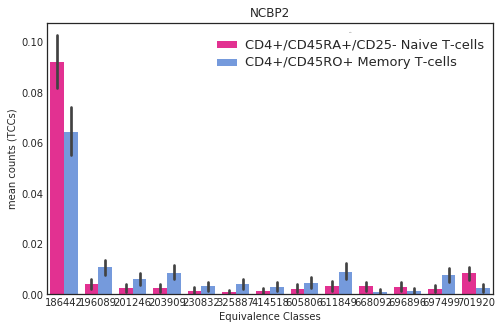

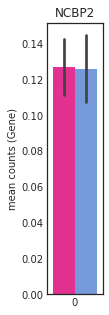

['NUDCD2']
	 GENE_pval:  0.300511336253
	 LogR pval:  0.000565029146606


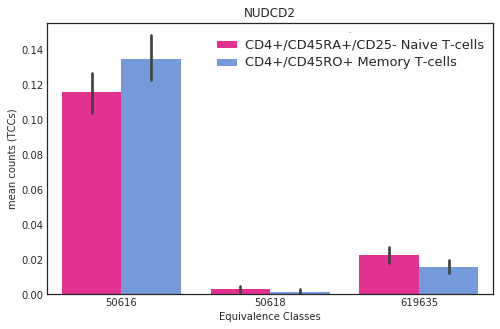

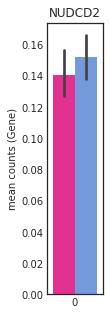

['NUPL2']
	 GENE_pval:  0.951083744436
	 LogR pval:  0.00321231662937


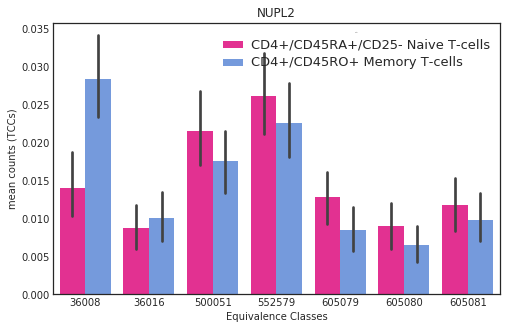

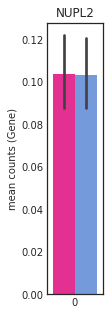

['PAIP2']
	 GENE_pval:  0.549804020304
	 LogR pval:  0.000390673633094


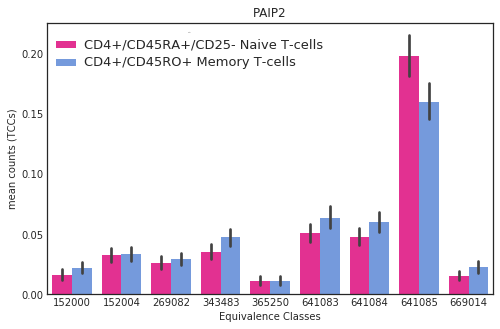

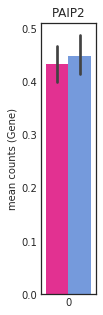

['PEX16']
	 GENE_pval:  0.556002544833
	 LogR pval:  0.00443791939145


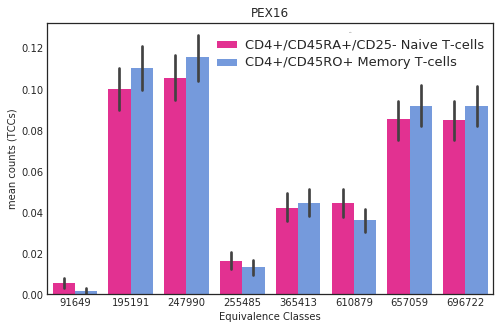

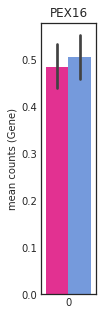

['PHF20']
	 GENE_pval:  0.499814302449
	 LogR pval:  9.37112282668e-05


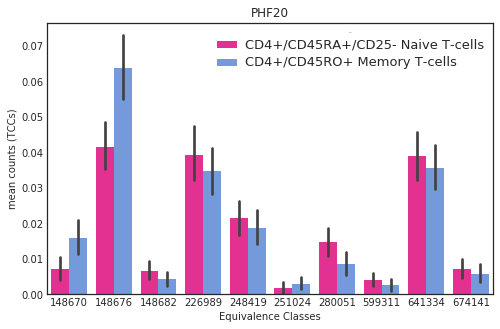

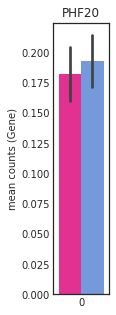

['PRPF38B']
	 GENE_pval:  0.541452545796
	 LogR pval:  2.11559278751e-06


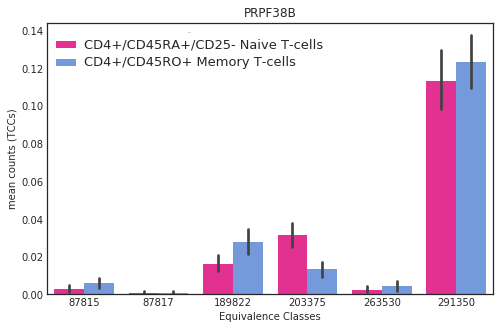

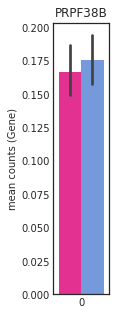

['PTPRC']
	 GENE_pval:  0.34082120543
	 LogR pval:  0.000256250881446


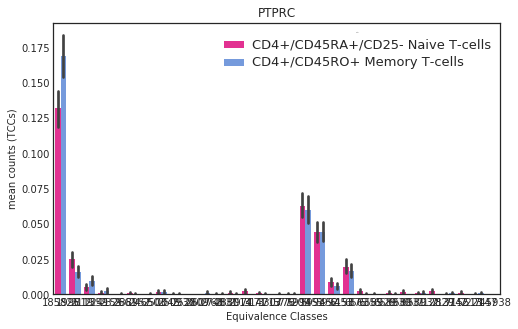

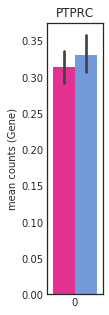

['RSRC2']
	 GENE_pval:  0.562686675848
	 LogR pval:  0.00273042755499


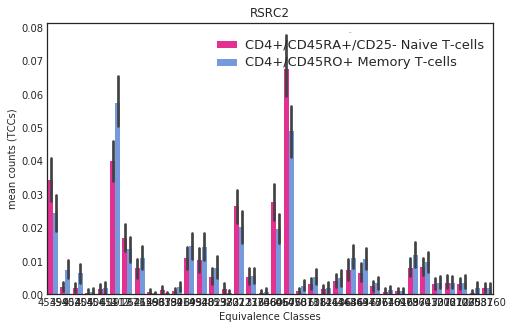

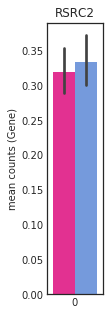

['SEPT7']
	 GENE_pval:  0.707705733734
	 LogR pval:  0.0


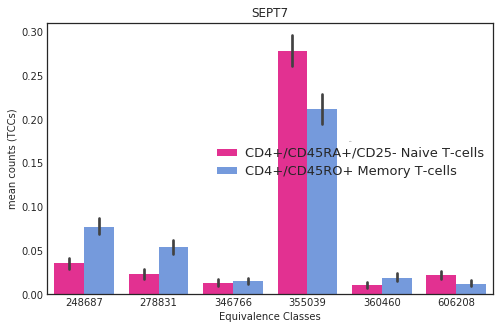

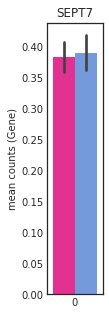

['SEPT9']
	 GENE_pval:  0.76233360336
	 LogR pval:  0.000309682941895


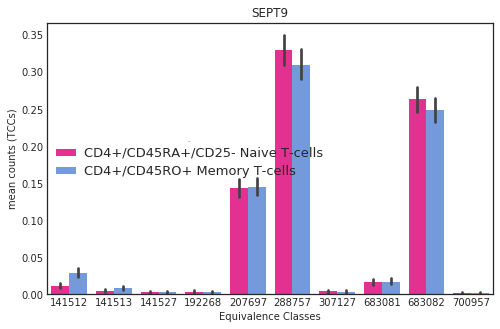

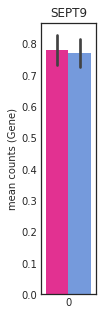

['SLC25A3']
	 GENE_pval:  0.87474814152
	 LogR pval:  0.000132777943868


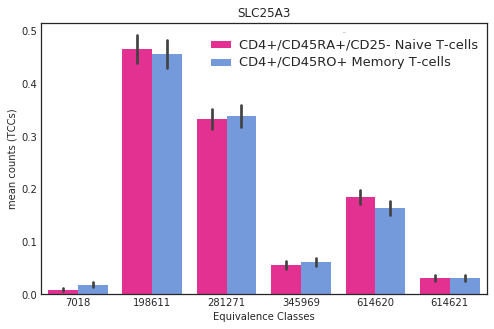

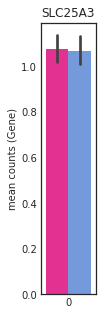

['SMIM7']
	 GENE_pval:  0.416333418856
	 LogR pval:  2.19905297305e-08


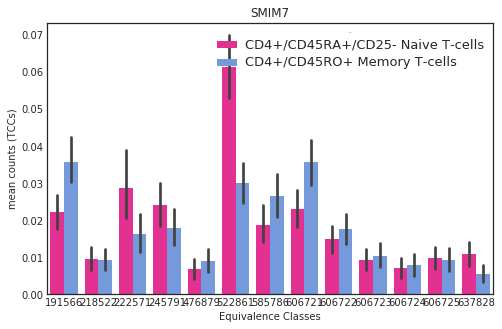

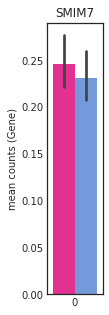

['SRSF3']
	 GENE_pval:  0.689945881375
	 LogR pval:  7.05865765838e-09


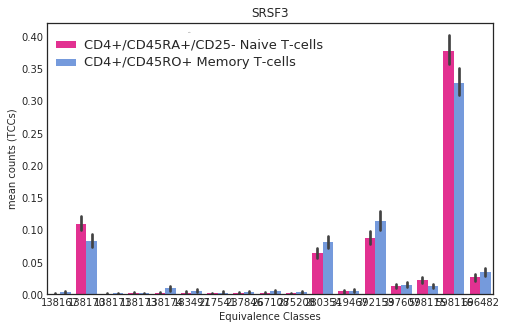

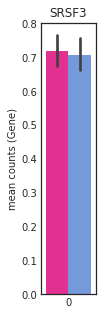

['SSR1']
	 GENE_pval:  0.634175998045
	 LogR pval:  3.3056949067e-08


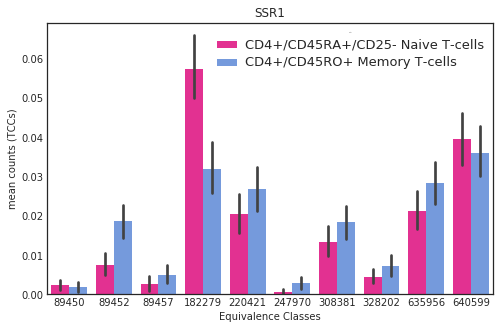

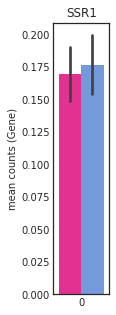

['SSR2']
	 GENE_pval:  0.930966956538
	 LogR pval:  0.000541853805469


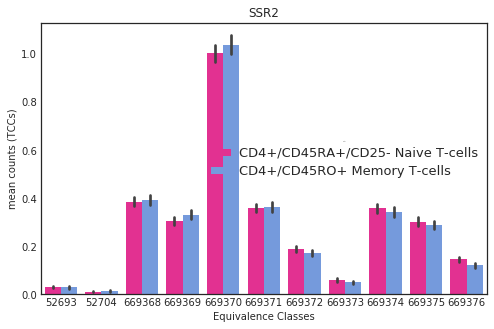

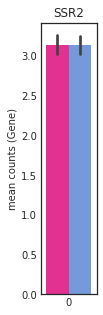

['SSU72']
	 GENE_pval:  0.361533363839
	 LogR pval:  0.000395372099567


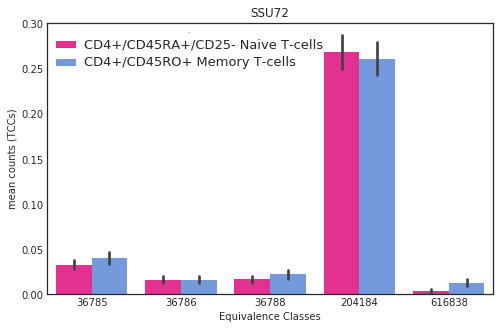

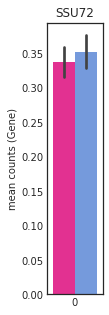

['TAF1D']
	 GENE_pval:  0.566222089569
	 LogR pval:  0.00312979287872


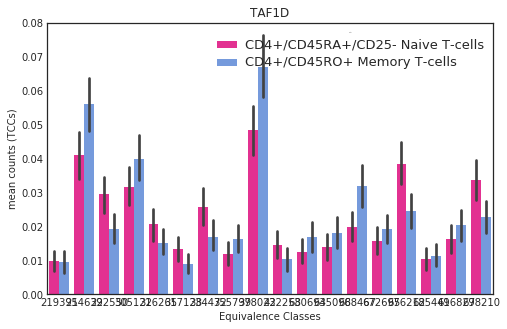

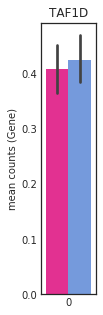

['THEM4']
	 GENE_pval:  0.34448362759
	 LogR pval:  3.87289988458e-05


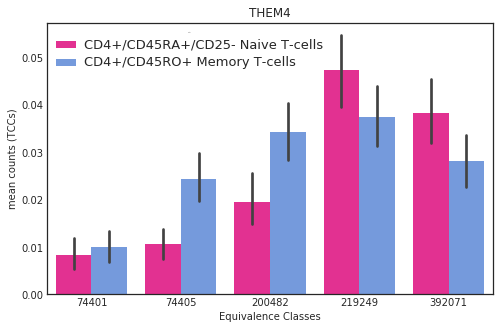

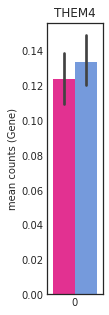

['TMBIM6']
	 GENE_pval:  0.812901242733
	 LogR pval:  0.0


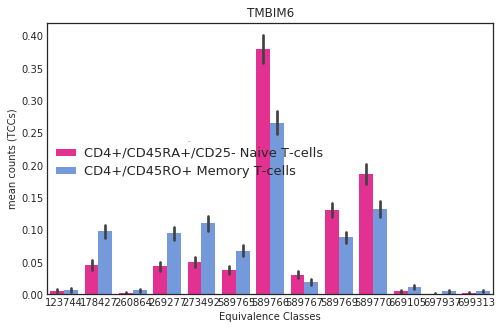

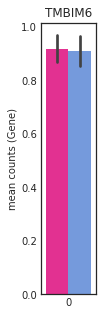

['XBP1']
	 GENE_pval:  0.868852356727
	 LogR pval:  3.87461887352e-06


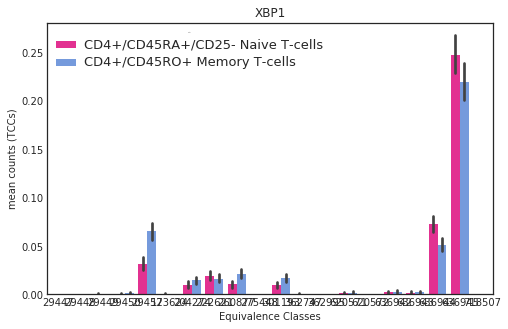

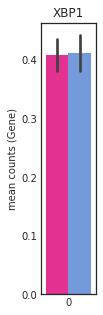

['ZNF331']
	 GENE_pval:  0.296557749824
	 LogR pval:  0.000207762073751


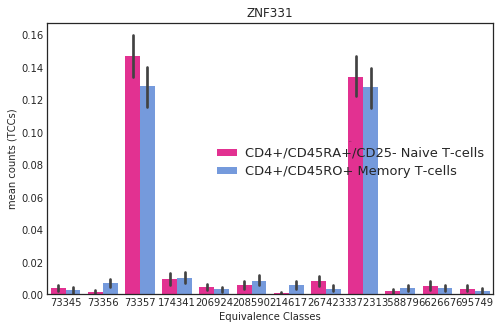

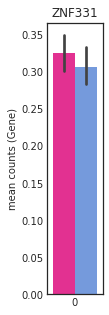

CPU times: user 36min 18s, sys: 2min 19s, total: 38min 38s
Wall time: 9min 10s


In [65]:
%%time
for gene in gnames:

    gene_ecs0=[]
    for g in all_gene_names_to_id[gene]:
        gene_ecs0+=ENSG_EC_DICT[g]
    gene_ecs0=np.unique(gene_ecs0)

    ec_counts=[]
    for ec in gene_ecs0:
        ec_counts+=[T[EC_IDX[ec],:].sum()]

    argsrt=np.argsort(ec_counts)[::-1]

    firstk=1
    gene_ecs = gene_ecs0[argsrt[:firstk]]
    associated_genes=[]
    for ec in gene_ecs:
        associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
    associated_genes=np.unique(associated_genes)

    while len(associated_genes)==1:
        firstk=firstk+1
        if firstk==len(argsrt)+1: break
        gene_ecs = gene_ecs0[argsrt[:firstk]]
        associated_genes=[]
        for ec in gene_ecs:
            associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
        associated_genes=np.unique(associated_genes)
        
    if firstk>1:firstk-=1
    gene_ecs=gene_ecs0[argsrt[:firstk]]
    if len(gene_ecs)>0:
        associated_genes=[]
        for ec in gene_ecs:
            associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
        associated_genes=np.unique(associated_genes)
    if len(associated_genes)==1:
        ecidx=np.array([EC_IDX[ec] for ec in gene_ecs])
        Gexp_n = np.array(X_n[:,ecidx].todense().T.sum(axis=0))[0]
        Gexp_m = np.array(X_m[:,ecidx].todense().T.sum(axis=0))[0]
#         Gexp_c = np.array(X_c[:,ecidx].todense().T.sum(axis=0))[0]
        if 0.5*(np.mean(Gexp_n)+np.mean(Gexp_m))>0.1:
            N1=samp
            N2=samp
            logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
            logrG = LogisticRegression()
            p_of_1=N1/float(N1+N2)
            llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
            k=1
            c=np.concatenate([Gexp_n,Gexp_m]).reshape(-1, 1)
            logrG.fit(c,logr_labels)
            pred=np.array(logrG.predict_proba(c)[:,1])
            gene_score=log_loss(logr_labels,pred)
            llf=-gene_score*(N1+N2)
            llr=llf-llnull
            llr_pval = 1-stats.chi2.cdf(2*llr,k)
            if llr_pval>0.2:
                A=logr_ecidx(ecidx, X_n,X_m)
                if A[1]<0.005:
                    print(associated_genes)
                    print("\t GENE_pval: ",llr_pval)
                    print("\t LogR pval: ",A[1])
                    P1=pd.DataFrame(X_n[:,ecidx].todense(),columns=nonzero_ec[ecidx])
                    P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
                    P2=pd.DataFrame(X_m[:,ecidx].todense(),columns=nonzero_ec[ecidx])
                    P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
                    P=P1.append(P2)
                    df = pd.melt(P,  id_vars='cluster')

                    plt.figure(figsize=(8,5))
                    ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493","#6495ED"], data=df)
                    ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
                    plt.title(associated_genes[0])
                    plt.setp(ax.get_legend().get_texts(), fontsize='13') 
                    plt.setp(ax.get_legend().get_title(), fontsize='0')
                    plt.show()




                    P1=pd.DataFrame(Gexp_n.T,)
                    P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
                    P2=pd.DataFrame(Gexp_m.T)
                    P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
                    P=P1.append(P2)
                    df = pd.melt(P,  id_vars='cluster')

                    plt.figure(figsize=(1,5))
                    ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493","#6495ED"], data=df)
                    ax.set(xlabel='', ylabel='mean counts (Gene)')
                    ax.legend_.remove()
                    plt.title(associated_genes[0])
                    plt.show()


        
        
    

# clean_ecs=np.unique(clean_ecs)

### random seed 3

In [66]:
samp = 4000

np.random.seed(3)
randperm1=np.random.permutation(X_naive.shape[0])
randperm2=np.random.permutation(X_mem.shape[0])
# randperm3=np.random.permutation(X_cyto.shape[0])

X_n = X_naive[randperm1[:samp],:]
X_m = X_mem[randperm2[:samp],:]
# X_c = X_cyto[randperm3[:samp],:]

['ACP1']
	 GENE_pval:  0.61424846462
	 LogR pval:  1.66627671538e-06


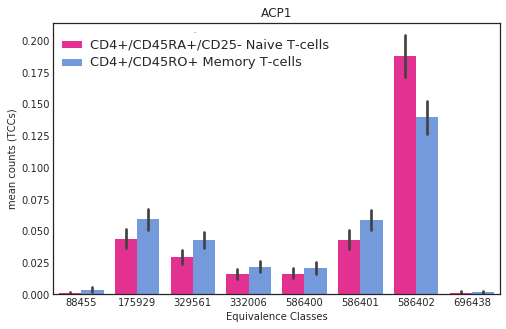

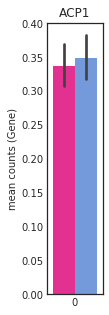

['ATP5A1']
	 GENE_pval:  0.364626212152
	 LogR pval:  1.09912079438e-14


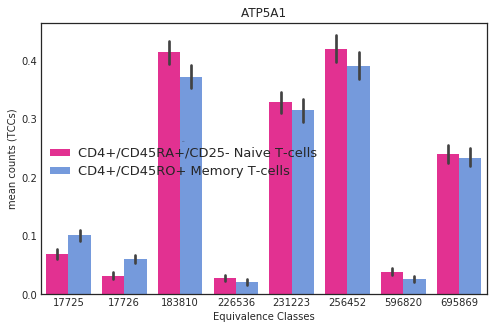

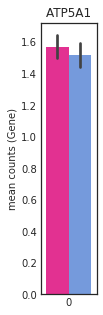

['BIN2']
	 GENE_pval:  0.571461516297
	 LogR pval:  0.00272399077923


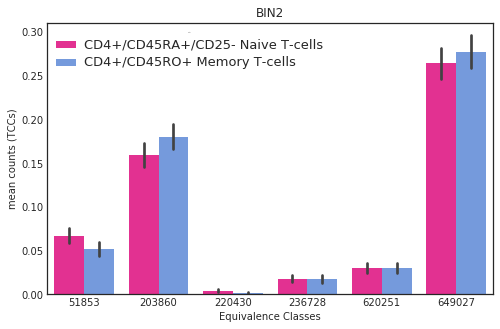

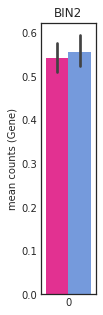

['CCDC59']
	 GENE_pval:  0.341234972225
	 LogR pval:  0.00390147139236


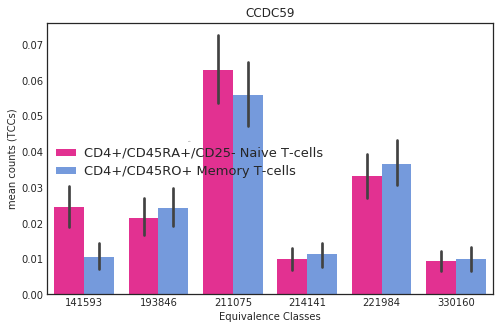

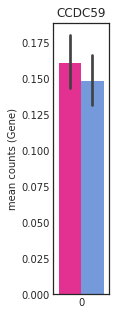

['CD46']
	 GENE_pval:  0.241369105841
	 LogR pval:  8.49834255847e-05


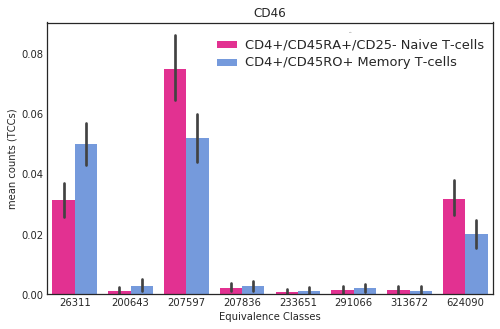

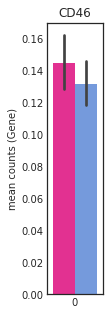

['CHCHD7']
	 GENE_pval:  0.944015480743
	 LogR pval:  5.45763790289e-05


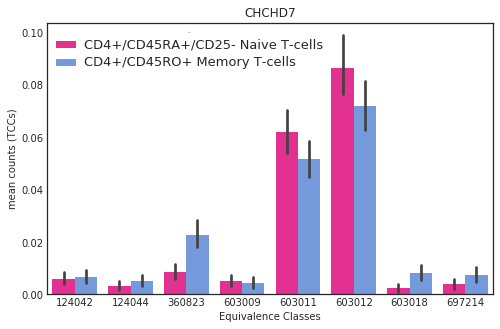

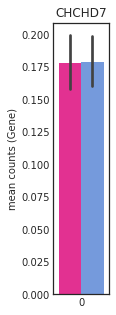

['COA1']
	 GENE_pval:  0.298953886495
	 LogR pval:  0.00213503317554


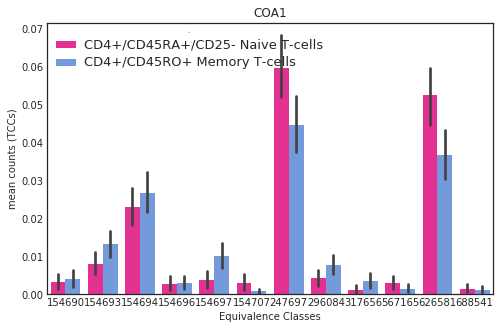

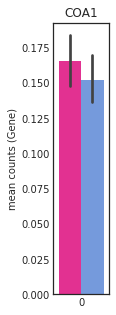

['DDX17']
	 GENE_pval:  0.384889090205
	 LogR pval:  0.000110962479551


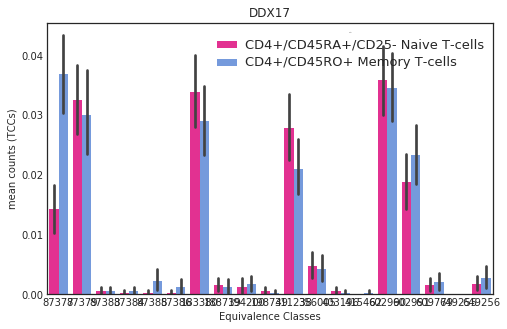

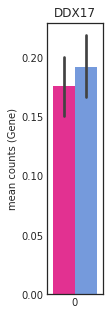

['DNAJB6']
	 GENE_pval:  0.658003943296
	 LogR pval:  0.000190494134404


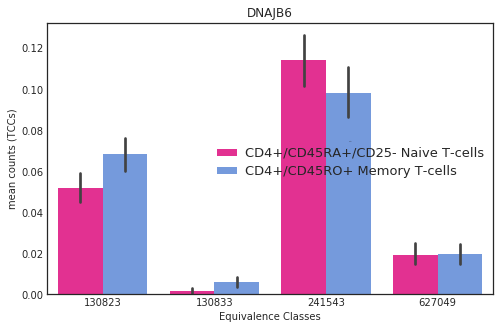

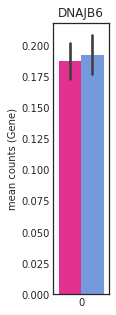

['DNAJC8']
	 GENE_pval:  0.214810326104
	 LogR pval:  2.84634952841e-06


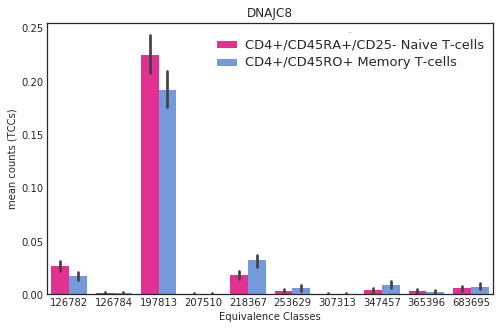

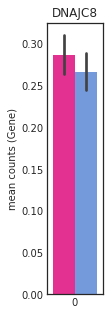

['EIF2D']
	 GENE_pval:  0.288348068868
	 LogR pval:  6.78034295376e-11


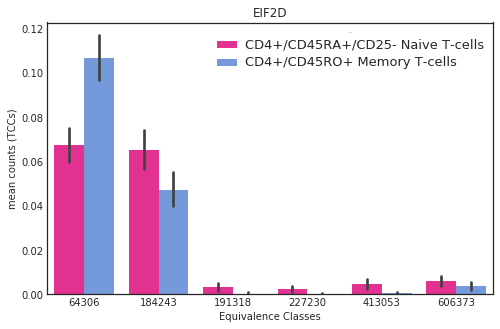

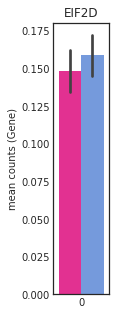

['EIF4B']
	 GENE_pval:  0.696581883826
	 LogR pval:  7.69981707172e-07


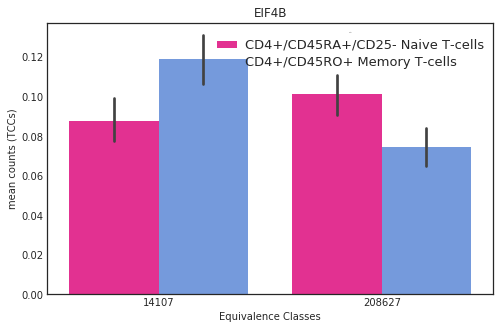

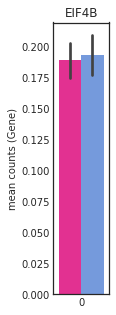

['FNTA']
	 GENE_pval:  0.964697844803
	 LogR pval:  0.000561491033285


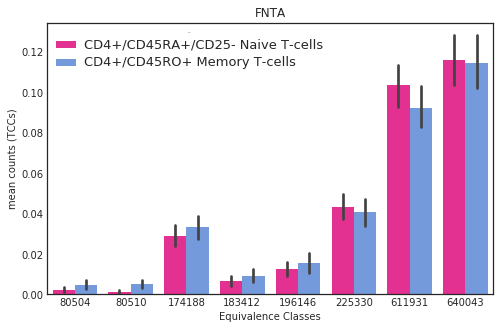

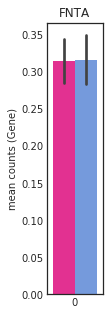

['FOXN3']
	 GENE_pval:  0.465420447146
	 LogR pval:  4.46415449197e-05


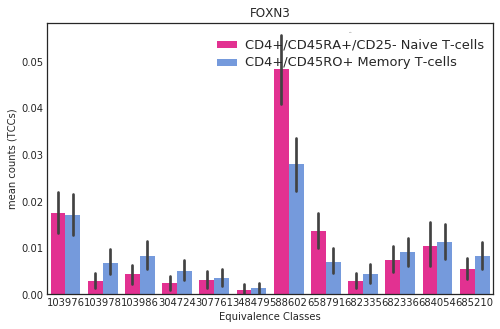

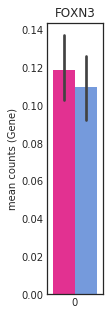

['FYB1']
	 GENE_pval:  0.880688691743
	 LogR pval:  0.000219901087762


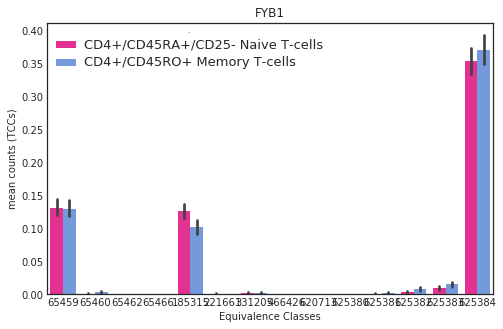

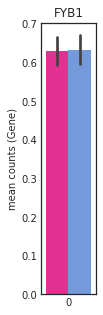

['GIMAP4']
	 GENE_pval:  0.275314894452
	 LogR pval:  2.12004095386e-05


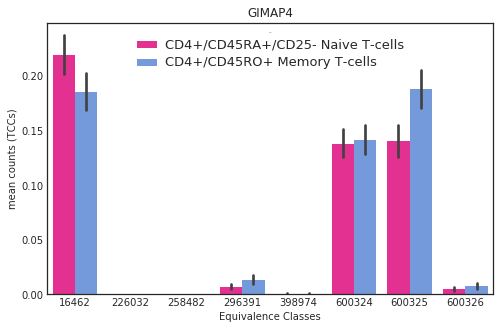

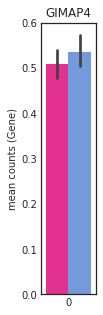

['LAT']
	 GENE_pval:  0.549284062929
	 LogR pval:  0.000711663628145


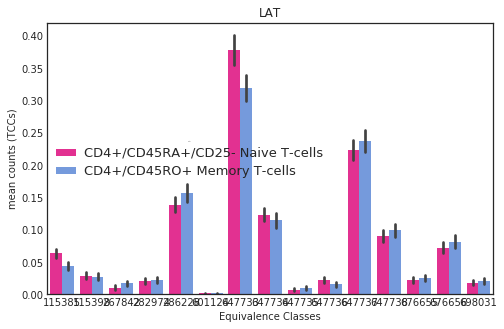

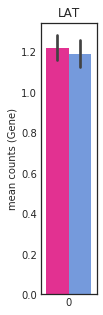

['LEPROTL1']
	 GENE_pval:  0.215885943738
	 LogR pval:  7.37905418227e-05


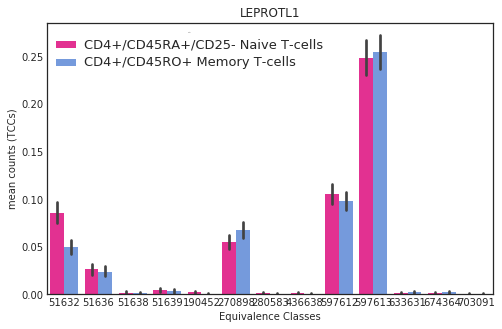

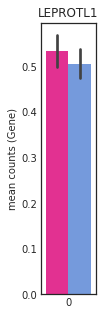

['MAPK1IP1L']
	 GENE_pval:  0.21044360152
	 LogR pval:  0.000198460860809


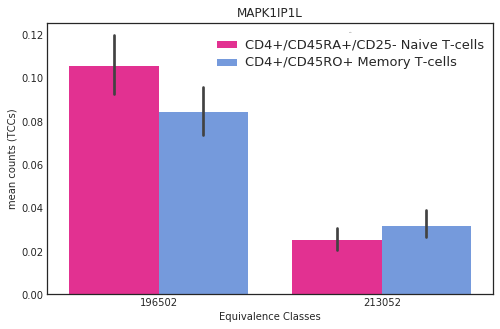

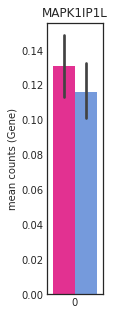

['MBNL1']
	 GENE_pval:  0.90107129127
	 LogR pval:  1.01030295241e-14


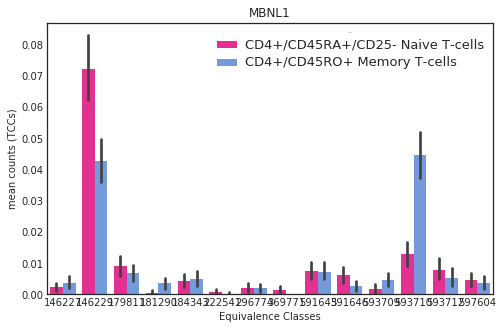

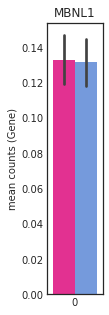

['MITD1']
	 GENE_pval:  0.661296072561
	 LogR pval:  7.08096361901e-05


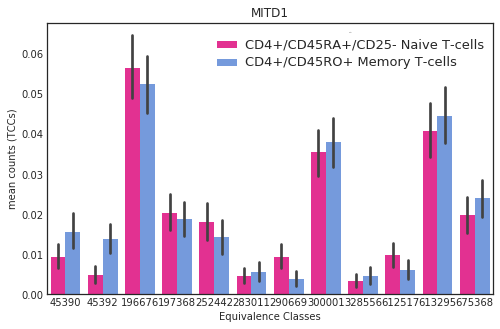

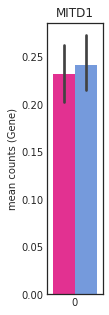

['MRPL2']
	 GENE_pval:  0.274061787679
	 LogR pval:  0.000539831680413


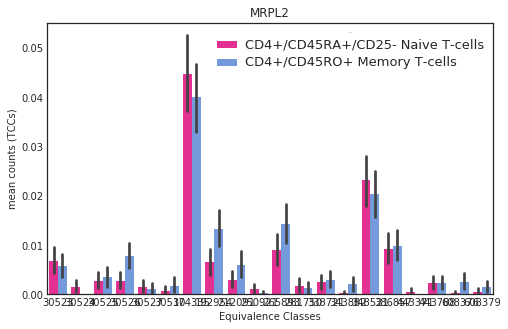

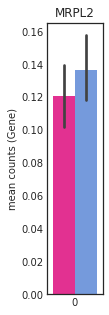

['MRPL3']
	 GENE_pval:  0.804444557881
	 LogR pval:  0.00236214042952


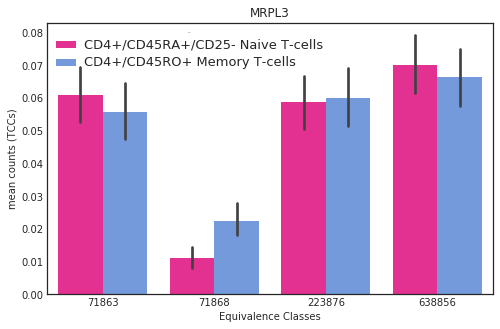

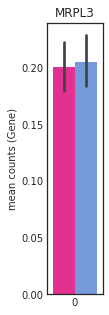

['MRPS7']
	 GENE_pval:  0.363018509235
	 LogR pval:  0.000270387448182


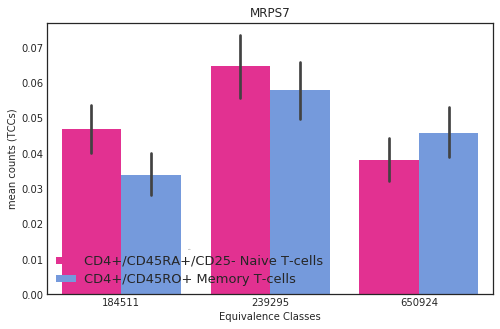

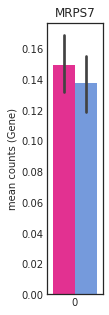

['MTERF4']
	 GENE_pval:  0.492432884624
	 LogR pval:  4.99933459659e-05


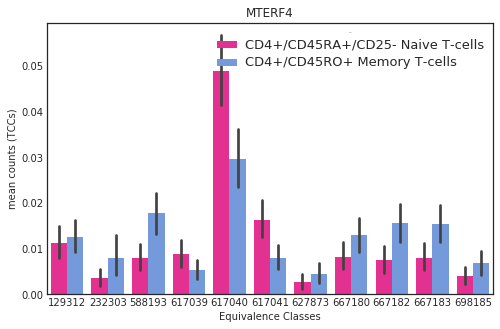

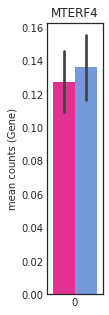

['NCBP2']
	 GENE_pval:  0.333845727936
	 LogR pval:  3.59918538653e-05


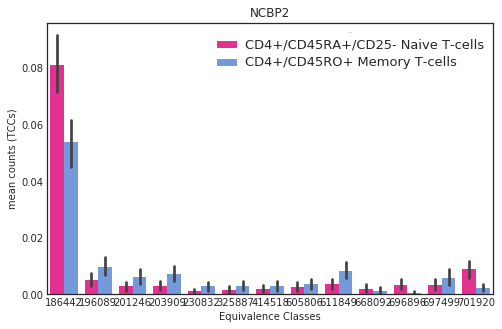

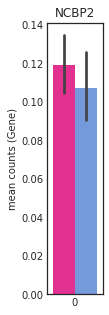

['NCOR1']
	 GENE_pval:  0.200969101308
	 LogR pval:  2.50627408716e-07


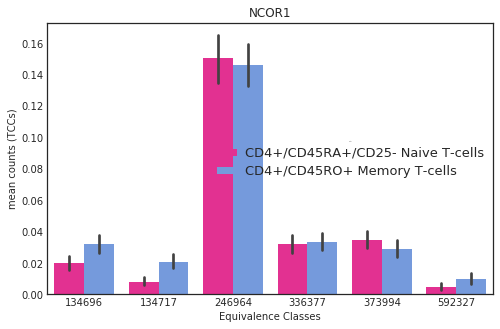

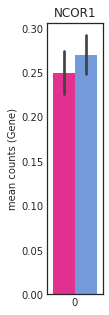

['NUPL2']
	 GENE_pval:  0.787618687739
	 LogR pval:  0.000303843194564


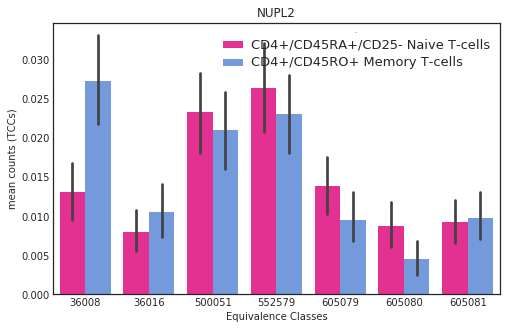

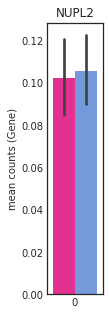

['PEX16']
	 GENE_pval:  0.547591434538
	 LogR pval:  0.000280412937295


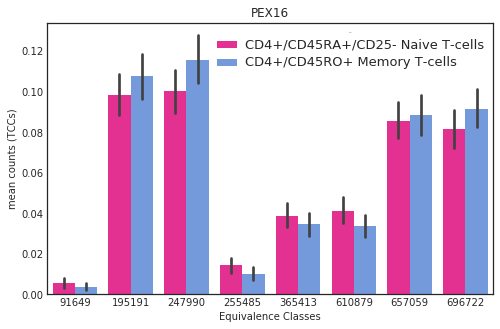

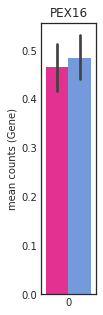

['PRPF38B']
	 GENE_pval:  0.607418659265
	 LogR pval:  0.00428031021546


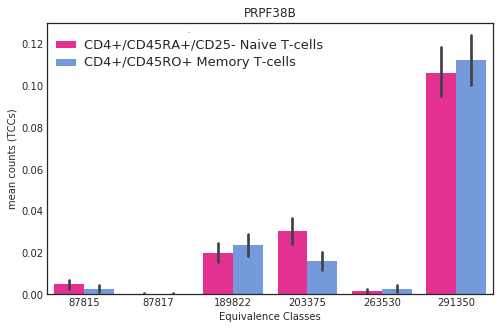

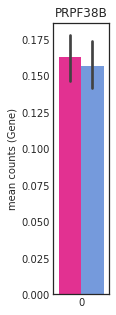

['PTPN2']
	 GENE_pval:  0.551180596093
	 LogR pval:  0.004689043257


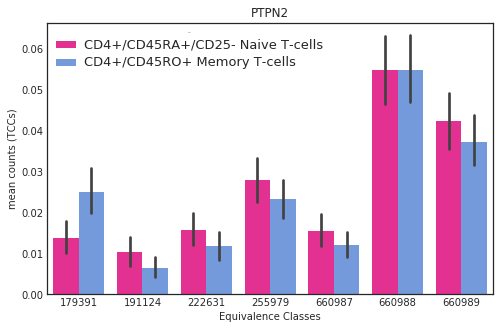

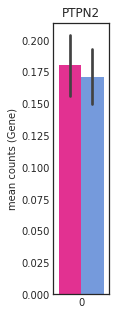

['RSRC2']
	 GENE_pval:  0.729635250211
	 LogR pval:  0.000523775466255


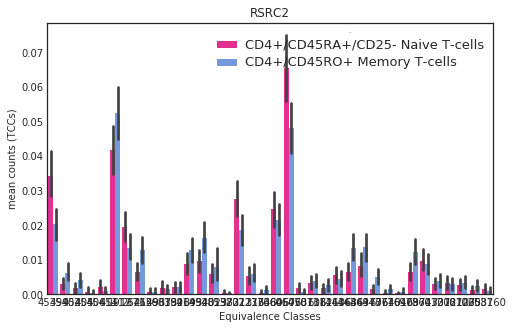

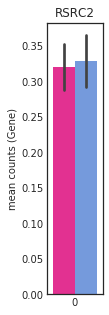

['SECISBP2']
	 GENE_pval:  0.524516641383
	 LogR pval:  0.0030978878441


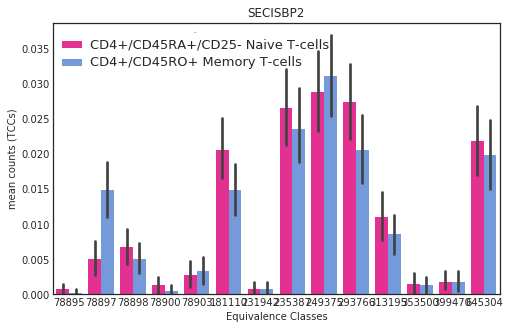

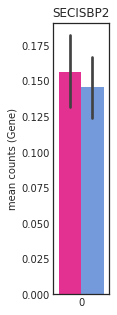

['SMIM7']
	 GENE_pval:  0.315265340321
	 LogR pval:  7.16655623734e-11


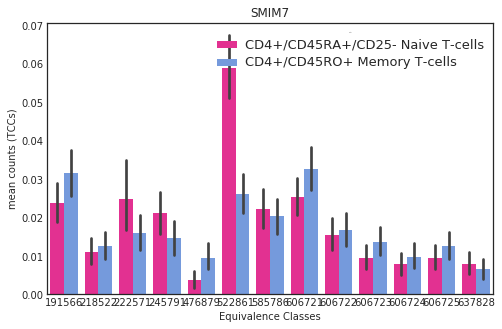

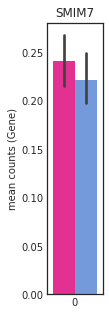

['SNW1']
	 GENE_pval:  0.458351211204
	 LogR pval:  0.000488770398537


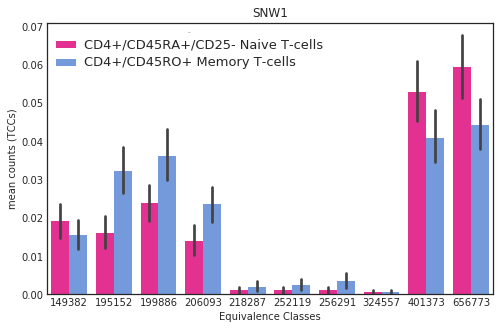

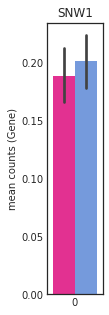

['SRSF3']
	 GENE_pval:  0.772932353821
	 LogR pval:  7.18021485602e-08


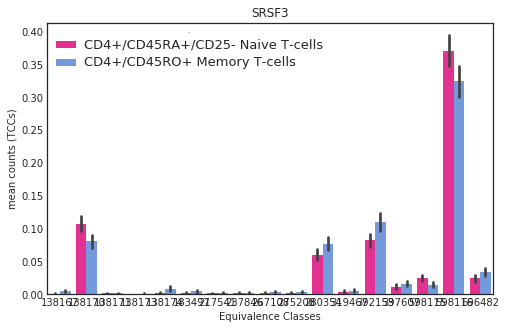

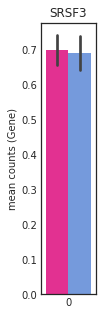

['SSR1']
	 GENE_pval:  0.387028792099
	 LogR pval:  8.22247161469e-08


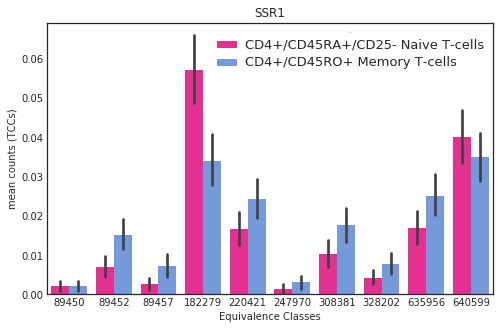

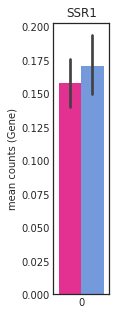

['SSR2']
	 GENE_pval:  0.791321454086
	 LogR pval:  8.55552395596e-09


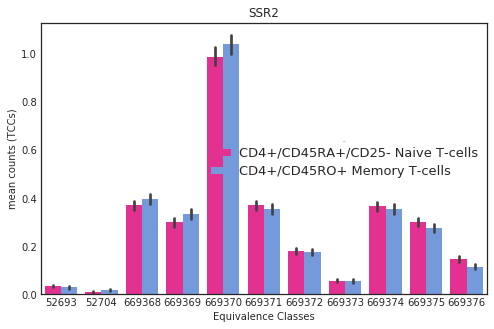

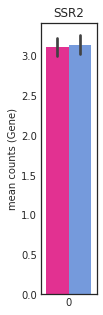

['SUMO3']
	 GENE_pval:  0.499704743326
	 LogR pval:  0.000265305083841


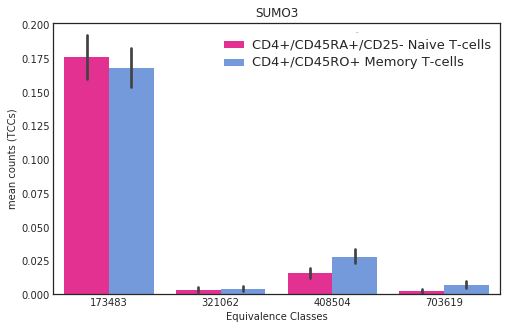

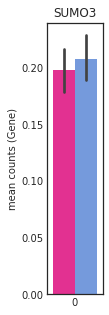

['TAX1BP1']
	 GENE_pval:  0.67965109441
	 LogR pval:  0.00420870767518


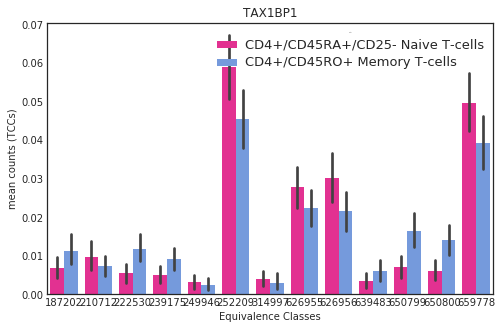

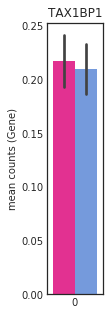

['THEM4']
	 GENE_pval:  0.388531730025
	 LogR pval:  4.97970880433e-05


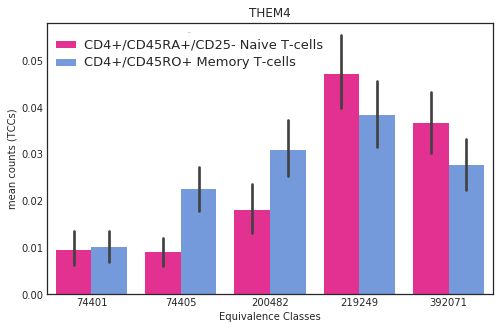

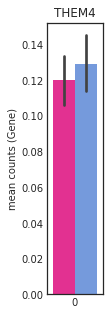

['TMBIM6']
	 GENE_pval:  0.521267966039
	 LogR pval:  0.0


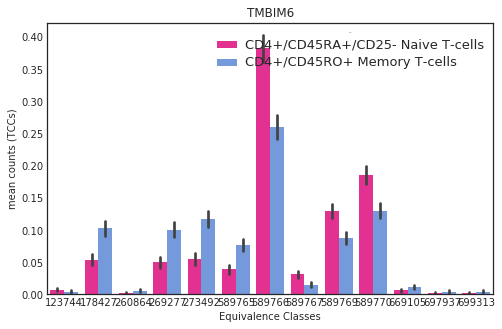

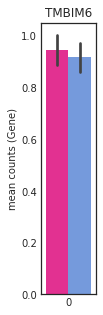

['UBAC2']
	 GENE_pval:  0.272129238696
	 LogR pval:  6.37923751601e-07


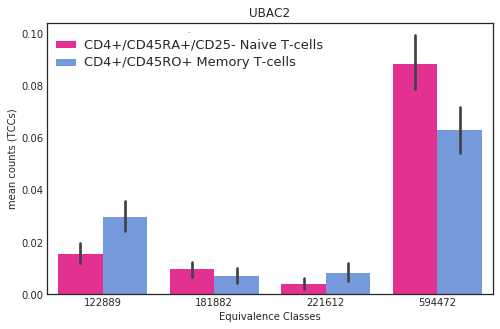

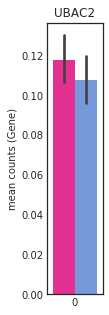

['UBE2B']
	 GENE_pval:  0.950954004223
	 LogR pval:  0.000332167659101


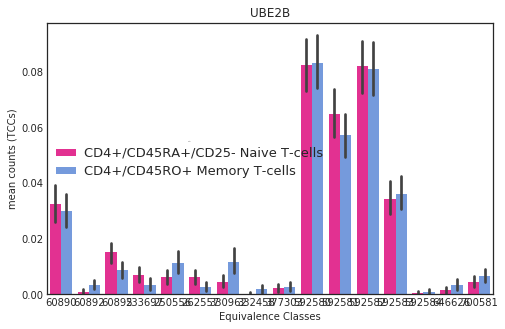

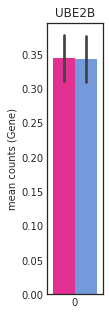

['UBE2D2']
	 GENE_pval:  0.707353994236
	 LogR pval:  0.000129314621616


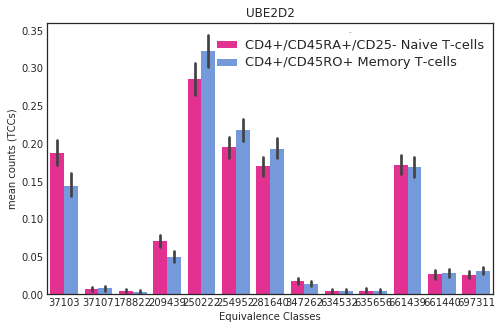

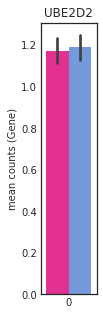

['USP16']
	 GENE_pval:  0.54400283551
	 LogR pval:  1.02730544853e-05


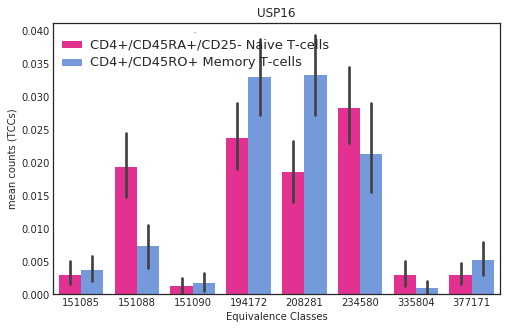

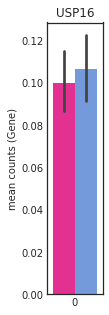

['VAMP2']
	 GENE_pval:  0.637244485511
	 LogR pval:  0.00145892778527


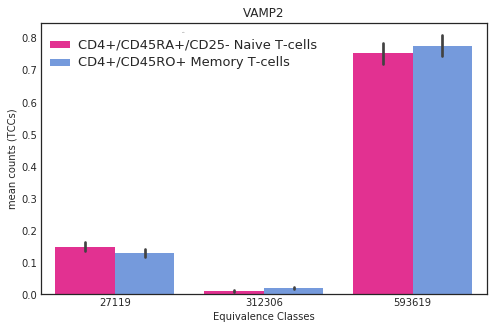

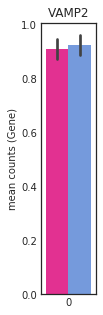

['XBP1']
	 GENE_pval:  0.982323925347
	 LogR pval:  1.46364032005e-11


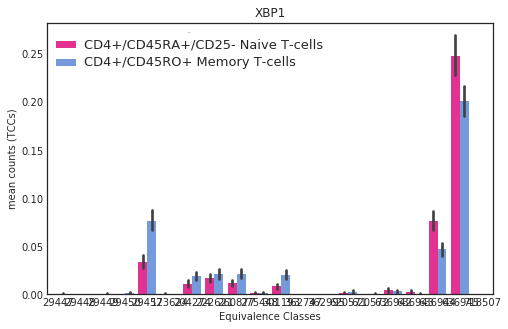

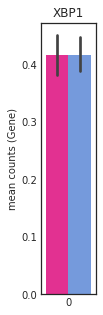

['ZNF331']
	 GENE_pval:  0.800125922205
	 LogR pval:  1.3045684459e-05


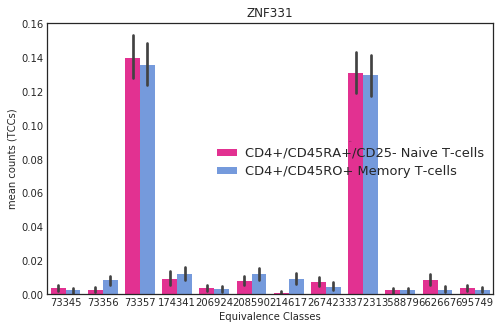

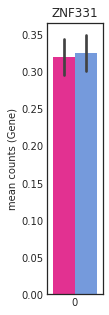

['ZRANB2']
	 GENE_pval:  0.22470805586
	 LogR pval:  0.000672581782272


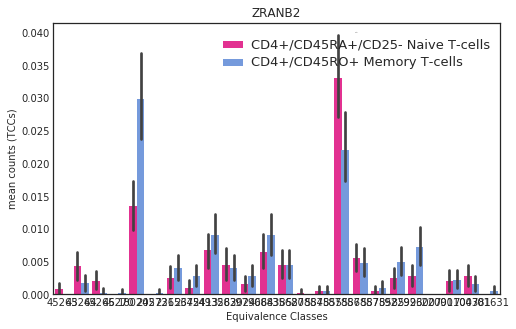

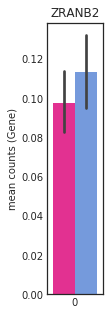

CPU times: user 35min 50s, sys: 2min 17s, total: 38min 8s
Wall time: 8min 53s


In [67]:
%%time
for gene in gnames:

    gene_ecs0=[]
    for g in all_gene_names_to_id[gene]:
        gene_ecs0+=ENSG_EC_DICT[g]
    gene_ecs0=np.unique(gene_ecs0)

    ec_counts=[]
    for ec in gene_ecs0:
        ec_counts+=[T[EC_IDX[ec],:].sum()]

    argsrt=np.argsort(ec_counts)[::-1]

    firstk=1
    gene_ecs = gene_ecs0[argsrt[:firstk]]
    associated_genes=[]
    for ec in gene_ecs:
        associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
    associated_genes=np.unique(associated_genes)

    while len(associated_genes)==1:
        firstk=firstk+1
        if firstk==len(argsrt)+1: break
        gene_ecs = gene_ecs0[argsrt[:firstk]]
        associated_genes=[]
        for ec in gene_ecs:
            associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
        associated_genes=np.unique(associated_genes)
        
    if firstk>1:firstk-=1
    gene_ecs=gene_ecs0[argsrt[:firstk]]
    if len(gene_ecs)>0:
        associated_genes=[]
        for ec in gene_ecs:
            associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
        associated_genes=np.unique(associated_genes)
    if len(associated_genes)==1:
        ecidx=np.array([EC_IDX[ec] for ec in gene_ecs])
        Gexp_n = np.array(X_n[:,ecidx].todense().T.sum(axis=0))[0]
        Gexp_m = np.array(X_m[:,ecidx].todense().T.sum(axis=0))[0]
#         Gexp_c = np.array(X_c[:,ecidx].todense().T.sum(axis=0))[0]
        if 0.5*(np.mean(Gexp_n)+np.mean(Gexp_m))>0.1:
            N1=samp
            N2=samp
            logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
            logrG = LogisticRegression()
            p_of_1=N1/float(N1+N2)
            llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
            k=1
            c=np.concatenate([Gexp_n,Gexp_m]).reshape(-1, 1)
            logrG.fit(c,logr_labels)
            pred=np.array(logrG.predict_proba(c)[:,1])
            gene_score=log_loss(logr_labels,pred)
            llf=-gene_score*(N1+N2)
            llr=llf-llnull
            llr_pval = 1-stats.chi2.cdf(2*llr,k)
            if llr_pval>0.2:
                A=logr_ecidx(ecidx, X_n,X_m)
                if A[1]<0.005:
                    print(associated_genes)
                    print("\t GENE_pval: ",llr_pval)
                    print("\t LogR pval: ",A[1])
                    P1=pd.DataFrame(X_n[:,ecidx].todense(),columns=nonzero_ec[ecidx])
                    P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
                    P2=pd.DataFrame(X_m[:,ecidx].todense(),columns=nonzero_ec[ecidx])
                    P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
                    P=P1.append(P2)
                    df = pd.melt(P,  id_vars='cluster')

                    plt.figure(figsize=(8,5))
                    ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493","#6495ED"], data=df)
                    ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
                    plt.title(associated_genes[0])
                    plt.setp(ax.get_legend().get_texts(), fontsize='13') 
                    plt.setp(ax.get_legend().get_title(), fontsize='0')
                    plt.show()




                    P1=pd.DataFrame(Gexp_n.T,)
                    P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
                    P2=pd.DataFrame(Gexp_m.T)
                    P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
                    P=P1.append(P2)
                    df = pd.melt(P,  id_vars='cluster')

                    plt.figure(figsize=(1,5))
                    ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493","#6495ED"], data=df)
                    ax.set(xlabel='', ylabel='mean counts (Gene)')
                    ax.legend_.remove()
                    plt.title(associated_genes[0])
                    plt.show()


        
        
    

# clean_ecs=np.unique(clean_ecs)

# DE genes

In [68]:
DE_genes=['CD46',
'TMBIM6',
'XBP1',
'CALM3',
'GIMAP4',
'DDX17',
'SEPT7',
'MBNL1',
'ZRANB2']



In [69]:
samp = 3000

np.random.seed(1)

randperm1=np.random.permutation(X_naive.shape[0])
randperm2=np.random.permutation(X_mem.shape[0])
# randperm3=np.random.permutation(X_cyto.shape[0])

X_n = X_naive[randperm1[:samp],:]
X_m = X_mem[randperm2[:samp],:]
# X_c = X_cyto[randperm3[:samp],:]

['CD46']
	 GENE_pval:  0.536211174589
	 LogR pval:  0.000521738519923


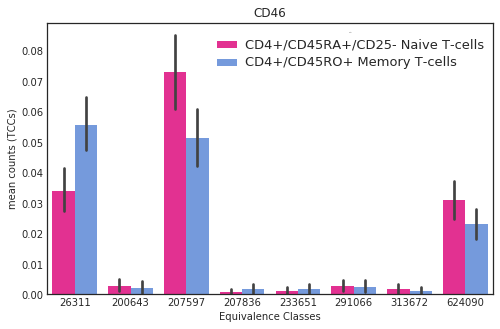

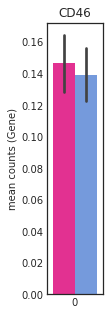

['TMBIM6']
	 GENE_pval:  0.942138747852
	 LogR pval:  0.0


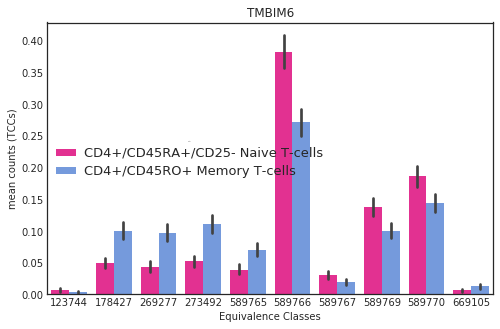

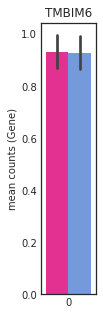

['XBP1']
	 GENE_pval:  0.579974601671
	 LogR pval:  1.23763332915e-10


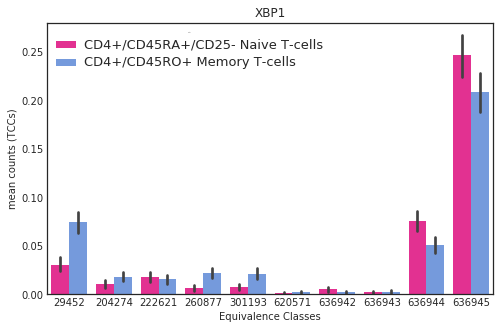

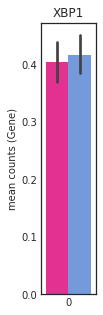

['CALM3']
	 GENE_pval:  0.518781277424
	 LogR pval:  0.0


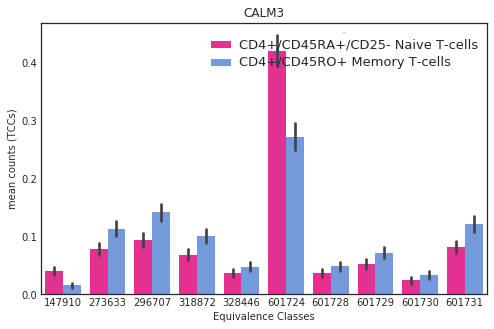

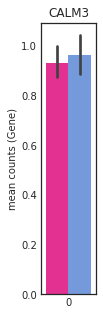

['GIMAP4']
	 GENE_pval:  0.782215196663
	 LogR pval:  0.000924777313975


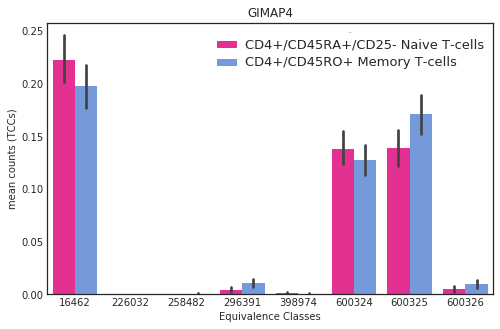

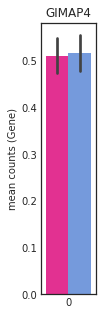

['DDX17']
	 GENE_pval:  0.547883187607
	 LogR pval:  6.73415612162e-09


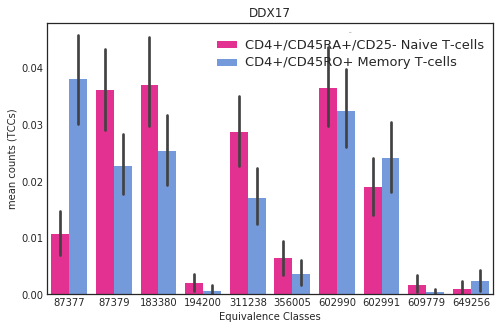

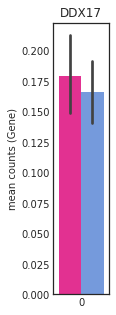

['SEPT7']
	 GENE_pval:  0.371457097897
	 LogR pval:  2.55273580052e-12


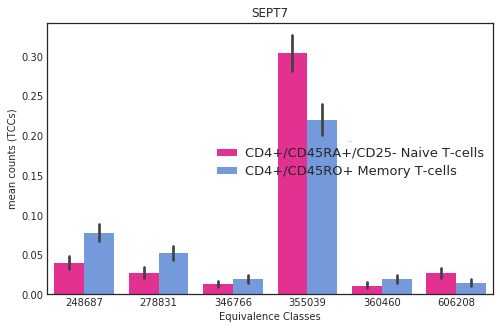

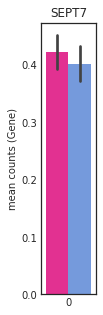

['MBNL1']
	 GENE_pval:  0.436252860399
	 LogR pval:  2.09046147059e-09


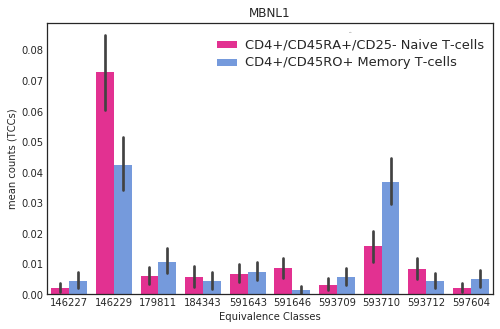

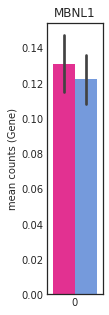

['ZRANB2']
	 GENE_pval:  0.767195196683
	 LogR pval:  0.00220069705265


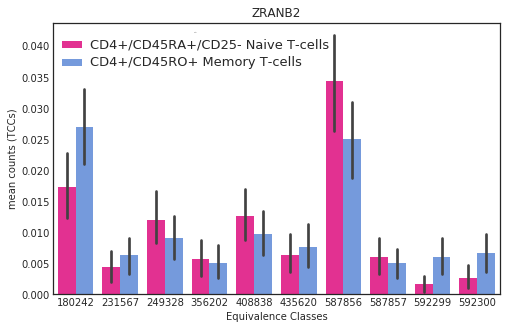

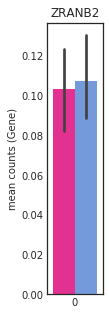

CPU times: user 46.8 s, sys: 2.48 s, total: 49.3 s
Wall time: 20.7 s


In [70]:
%%time
for gene in DE_genes:

    gene_ecs0=[]
    for g in all_gene_names_to_id[gene]:
        gene_ecs0+=ENSG_EC_DICT[g]
    gene_ecs0=np.unique(gene_ecs0)

    ec_counts=[]
    for ec in gene_ecs0:
        ec_counts+=[T[EC_IDX[ec],:].sum()]

    argsrt=np.argsort(ec_counts)[::-1]

    firstk=1
    gene_ecs = gene_ecs0[argsrt[:firstk]]
    associated_genes=[]
    for ec in gene_ecs:
        associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
    associated_genes=np.unique(associated_genes)

    while len(associated_genes)==1:
        firstk=firstk+1
        if firstk==len(argsrt)+1: break
        gene_ecs = gene_ecs0[argsrt[:firstk]]
        associated_genes=[]
        for ec in gene_ecs:
            associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
        associated_genes=np.unique(associated_genes)
        
    if firstk>1:firstk-=1
    if firstk>10:firstk=10 ################################ restrict to 10 largest ecs
    gene_ecs=gene_ecs0[argsrt[:firstk]]
    if len(gene_ecs)>0:
        associated_genes=[]
        for ec in gene_ecs:
            associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
        associated_genes=np.unique(associated_genes)
    if len(associated_genes)==1:
        ecidx=np.array([EC_IDX[ec] for ec in gene_ecs])
        Gexp_n = np.array(X_n[:,ecidx].todense().T.sum(axis=0))[0]
        Gexp_m = np.array(X_m[:,ecidx].todense().T.sum(axis=0))[0]
#         Gexp_c = np.array(X_c[:,ecidx].todense().T.sum(axis=0))[0]
        if 0.5*(np.mean(Gexp_n)+np.mean(Gexp_m))>0:
            N1=samp
            N2=samp
            logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
            logrG = LogisticRegression()
            p_of_1=N1/float(N1+N2)
            llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
            k=1
            c=np.concatenate([Gexp_n,Gexp_m]).reshape(-1, 1)
            logrG.fit(c,logr_labels)
            pred=np.array(logrG.predict_proba(c)[:,1])
            gene_score=log_loss(logr_labels,pred)
            llf=-gene_score*(N1+N2)
            llr=llf-llnull
            llr_pval = 1-stats.chi2.cdf(2*llr,k)
            if llr_pval>0:
                A=logr_ecidx(ecidx, X_n,X_m)
                if A[1]<1:
                    print(associated_genes)
                    print("\t GENE_pval: ",llr_pval)
                    print("\t LogR pval: ",A[1])
                    P1=pd.DataFrame(X_n[:,ecidx].todense(),columns=nonzero_ec[ecidx])
                    P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
                    P2=pd.DataFrame(X_m[:,ecidx].todense(),columns=nonzero_ec[ecidx])
                    P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
                    P=P1.append(P2)
                    df = pd.melt(P,  id_vars='cluster')

                    plt.figure(figsize=(8,5))
                    ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493","#6495ED"], data=df)
                    ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
                    plt.title(associated_genes[0])
                    plt.setp(ax.get_legend().get_texts(), fontsize='13') 
                    plt.setp(ax.get_legend().get_title(), fontsize='0')
                    plt.show()




                    P1=pd.DataFrame(Gexp_n.T,)
                    P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
                    P2=pd.DataFrame(Gexp_m.T)
                    P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
                    P=P1.append(P2)
                    df = pd.melt(P,  id_vars='cluster')

                    plt.figure(figsize=(1,5))
                    ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493","#6495ED"], data=df)
                    ax.set(xlabel='', ylabel='mean counts (Gene)')
                    ax.legend_.remove()
                    plt.title(associated_genes[0])
                    plt.show()


        
        
    

# clean_ecs=np.unique(clean_ecs)